# Hyperparameter Skunkworks Project

## Project Overview

In statistics, hyperparameter is a parameter from a prior distribution; it captures the prior belief before data is observed.
In any machine learning algorithms, these parameters need to be initialized before training a model.
Hyperparameters are important because they directly control the behaviour of the training algorithm and have a significant impact on the performance of the model which is being trained.
Our aim is to find proper hyperparameter with proper tuning for our dataset which would help the database team in modelling the database schema in an efficient way. We would create H2O models for this dataset for getting proper hyperparameters.

### Background Research

Hyperparameters: In machine learning, we use the term hyperparameter to distinguish from standard model parameters. A machine learning model is the definition of a mathematical formula with a number of parameters that need to be learned from the data. That is the crux of machine learning: fitting a model to the data. This is done through a process known as model training. In other words, by training a model with existing data, we are able to fit the model parameters.

H2O: H2O is java based softwaere for data modelling and general computing. The goal of H2O is to allow simple horizontal scaling to a given problem in order to produce a solution faster. H2O uses a distributed key-value store (the “DKV”) that contains pointers to the various objects of the H2O ecosystem. Some shared objects are mutable by the client; some shared objects are read-only by the client, but are mutable by H2O (e.g. a model being constructed will change over time); and actions by the client may have side-effects on other clients (multi-tenancy is not a supported model of use, but it is possible for multiple clients to attach to a single H2O cloud).

### How to find hyperparameters?

1. Find Dataset
2. Figure out algorithm which we are using for the dataset. The type of algorithm which we used is regression
3. Perform H2O in python for generating various Models for different runtime
4. Further we have to communicate with the database team and have to give them hyperparameters JSON files generated

# Data Description

Abstract: The data is related with Black Friday Sale. The Product Category, Total Sales of the data and purchase and gender. My target variable is Purchase.

# Data

User ID, Product ID, Gender, Age, Occupation, City Category, Marital_Status, Product Category 1, Product Category 2, Product Category 3, Purchase 

# Acknowledgement

Source: All these data sets are made up of data from the US government. Data from the World Factbook is public domain. The website says "The World Factbook is in the public domain and may be used freely by anyone at anytime without seeking permission." https://www.cia.gov/library/publications/the-world-factbook/docs/faqs.html

In [12]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression

In [4]:
# importing the dataset
df=pd.read_csv("BlackFriday.csv", decimal = ',')

In [3]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [4]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.375770e+05,537577.00000,537577.000000,537577.000000,370591.000000,164278.000000,537577.000000
mean,1.002992e+06,8.08271,0.408797,5.295546,9.842144,12.669840,9333.859853
std,1.714393e+03,6.52412,0.491612,3.750701,5.087259,4.124341,4981.022133
min,1.000001e+06,0.00000,0.000000,1.000000,2.000000,3.000000,185.000000
25%,1.001495e+06,2.00000,0.000000,1.000000,5.000000,9.000000,5866.000000
50%,1.003031e+06,7.00000,0.000000,5.000000,9.000000,14.000000,8062.000000
75%,1.004417e+06,14.00000,1.000000,8.000000,15.000000,16.000000,12073.000000
max,1.006040e+06,20.00000,1.000000,18.000000,18.000000,18.000000,23961.000000


In [5]:
df.isnull().values.any()

True

In [6]:
df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            166986
Product_Category_3            373299
Purchase                           0
dtype: int64

# EDA

In [7]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


(537577, 12)

In [8]:
count_m = df[df['Gender']=='M'].count()[0]
count_f = df[df['Gender']=='F'].count()[0]

In [9]:
print('Number of male clients:',count_m)
print('Number of female clients:',count_f)

Number of male clients: 405380
Number of female clients: 132197


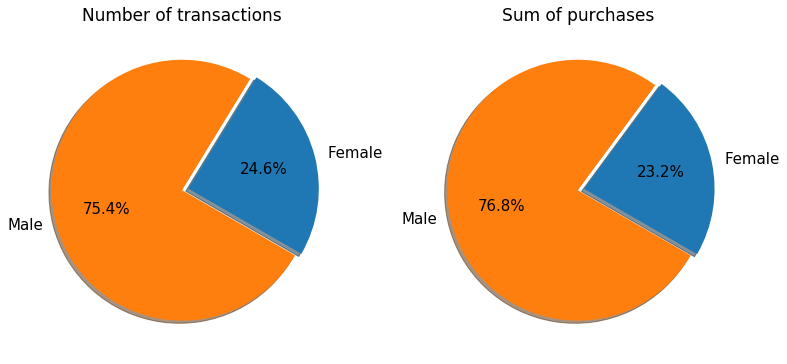

In [10]:
plt.figure(figsize=(13, 6))
gender_gb = df[['Gender', 'Purchase']].groupby('Gender').agg(['count', 'sum'])
params = {
#     'colors': [(255/255, 102/255, 102/255, 1), (102/255, 179/255, 1, 1)],
    'labels': gender_gb.index.map({'M': 'Male', 'F': 'Female'}),
    'autopct': '%1.1f%%',
    'startangle': -30, 
    'textprops': {'fontsize': 15},
    'explode': (0.05, 0),
    'shadow': True
}
plt.subplot(121)
plt.pie(gender_gb['Purchase']['count'], **params)
plt.title('Number of transactions', size=17)
plt.subplot(122)
plt.pie(gender_gb['Purchase']['sum'], **params)
plt.title('Sum of purchases', size=17)
plt.show()

Men have had transactions about 3 times higher than women in black friday. They've also had proportionaly higher purchase amount, which leads to the assumption that there is no meaningful difference between mean purchase amounts of men and women. Let's check that.

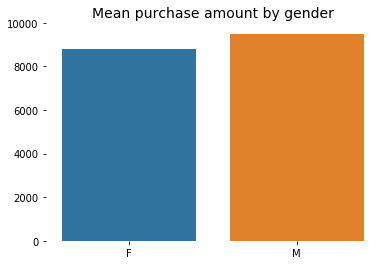

In [11]:
gender_gb = df[['Gender', 'Purchase']].groupby('Gender', as_index=False).agg('mean')
sns.barplot(x='Gender', y='Purchase', data=gender_gb)
plt.ylabel('')
plt.xlabel('')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.title('Mean purchase amount by gender', size=14)
plt.show()

# Age

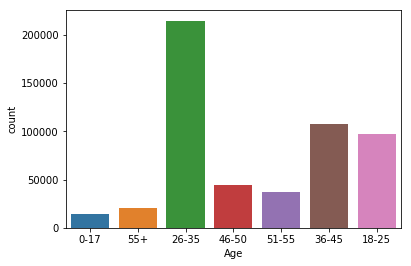

In [12]:
sns.countplot(df['Age'])

Further, I could also check among the age groups, which gender was a majority by adding a hue. And as seen below, more males spent in the sale than females.

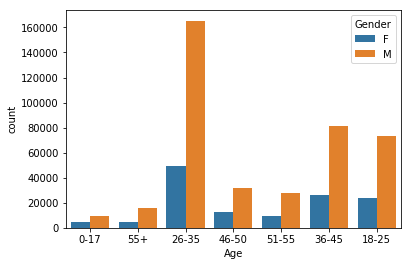

In [13]:
sns.countplot(df['Age'],hue=df['Gender'])

In [14]:
df['combined_G_M'] = df.apply(lambda x:'%s_%s' % (x['Gender'],x['Marital_Status']),axis=1)
print(df['combined_G_M'].unique())

['F_0' 'M_0' 'M_1' 'F_1']


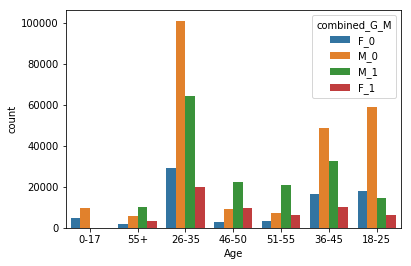

In [15]:
sns.countplot(df['Age'],hue=df['combined_G_M'])

As we see above, there are no bars for the married in the 0-17 range which makes sense. And then if we look at the 46 and above groups, females are very less. But on the other hand, married males paying in range 46-55 are also comparatively more than married females. So it could also imply that though ladies do shop a lot, their spouses are possibly paying for it and hence data reflects that men shopped more. If we had more categorical data defining what kind of products were purchased by men, we could dig in this statement further. However, since in this dataset we don't know if there is a category that implies feminine products/clothes we cannot further explore this case.

In [16]:
df.corr()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
User_ID,1.000000,-0.023024,0.018732,0.003687,0.001471,0.004045,0.005389
Occupation,-0.023024,1.000000,0.024691,-0.008114,-0.000031,0.013452,0.021104
Marital_Status,0.018732,0.024691,1.000000,0.020546,0.015116,0.019452,0.000129
Product_Category_1,0.003687,-0.008114,0.020546,1.000000,0.540423,0.229490,-0.314125
Product_Category_2,0.001471,-0.000031,0.015116,0.540423,1.000000,0.543544,-0.209973
Product_Category_3,0.004045,0.013452,0.019452,0.229490,0.543544,1.000000,-0.022257
Purchase,0.005389,0.021104,0.000129,-0.314125,-0.209973,-0.022257,1.000000


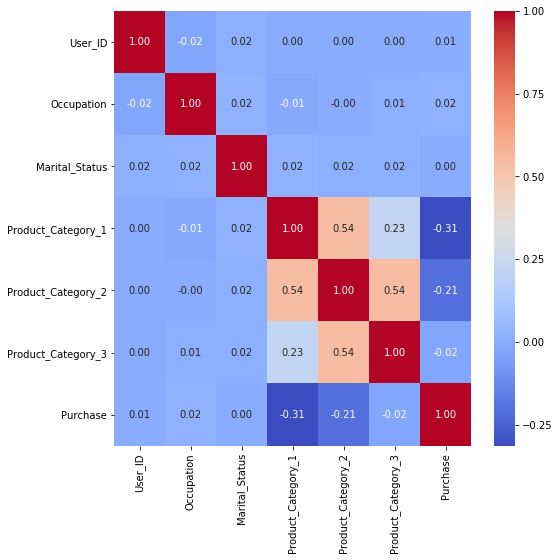

In [17]:
plt.figure(figsize=(8,8))
sns.heatmap(data=df.iloc[:,:].corr(),annot=True,fmt='.2f',cmap='coolwarm')
plt.show()

# H20

In [18]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=None
nthreads=1 
min_mem_size=6 
run_time=500
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

In [19]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

4


In [20]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str
  
 # function to set metadata 
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['server_path']=server
  m_data['data_path']=data 
  m_data['test_path']=test
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data

# function to convert dictionary to json file
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
  
  
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d
# function for getting model by algorithm
def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
# function for generating the statistic model of gbm    
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
# function for generating statistic model of dl    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
 # function for generating statistic model for drf algorithm   
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
# function for generating xrt model    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
# function for generating glm model    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
 # function for measuring performance   
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d
    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return

# function for generating variable importance
def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
 # function for getting all variables to csv   
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
    
# function for checking all variabls
def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
          if dct[key] not in ['real','int','enum']:                      
            targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
          if dct[key] != val:
            print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                  df[key] = df[key].asfactor() 
                except:
                  targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                  df[key] = df[key].asnumeric() 
                except:
                  targ.remove(key)                  
            if dct[key]=='real':
                try:                
                  df[key] = df[key].asnumeric()  
                except:
                  targ.remove(key)                  
    if y is None:
      y=df.columns[-1] 
    if y in targ:
      targ.remove(y)
    else:
      y=targ.pop()            
    return targ    
    
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    
    
#  End Functions

Generating the run id for each runtime

In [21]:
run_id=alphabet(9)
if server_path==None:
  server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print (run_id)

SwCipsp7b


Starting the H2O server

In [22]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)

Checking whether there is an H2O instance running at http://localhost:10193 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from C:\Users\vrush\.jupyter\AnacondaNew\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\vrush\AppData\Local\Temp\tmpzk1w7r7y
  JVM stdout: C:\Users\vrush\AppData\Local\Temp\tmpzk1w7r7y\h2o_vrush_started_from_python.out
  JVM stderr: C:\Users\vrush\AppData\Local\Temp\tmpzk1w7r7y\h2o_vrush_started_from_python.err
  Server is running at http://127.0.0.1:10193
Connecting to H2O server at http://127.0.0.1:10193 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,24 days
H2O cluster name:,H2O_from_python_vrush_k5c2oc
H2O cluster total nodes:,1
H2O cluster free memory:,3.833 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


Generating the metadata for each hyperparameter model at 500 Seconds

In [23]:

# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,test_path,model_path,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'start_time': 1556239103.204847, 'target': None, 'server_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\hyperparameter-db-project-ds05\\black-friday', 'data_path': None, 'test_path': None, 'max_models': 9, 'run_time': 500, 'run_id': 'SwCipsp7b', 'scale': False, 'classification': False, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1556239103.204847, 'execution_time': 0.0, 'run_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\hyperparameter-db-project-ds05\\black-friday\\SwCipsp7b', 'nthreads': 1, 'min_mem_size': 4, 'analysis': 0}


specifying the server path, run id, data path, classification, execution time

Converting dictionary to JSON files

In [24]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [25]:
meta_data = meta_data
n='Metadata_500.csv'

In [26]:
dict_to_json(meta_data,n)

In [27]:
df.to_csv('train1.csv')

In [28]:
data_path='train1.csv'


In [29]:
# Load data into H2O
train_data = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [30]:
train_data.head()

C1,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,combined_G_M
0,1e+06,P00069042,F,0-17,10,A,2,0,3,nan,nan,8370,F_0
1,1e+06,P00248942,F,0-17,10,A,2,0,1,6,14,15200,F_0
2,1e+06,P00087842,F,0-17,10,A,2,0,12,nan,nan,1422,F_0
3,1e+06,P00085442,F,0-17,10,A,2,0,12,14,nan,1057,F_0
4,1e+06,P00285442,M,55+,16,C,nan,0,8,nan,nan,7969,M_0
5,1e+06,P00193542,M,26-35,15,A,3,0,1,2,nan,15227,M_0
6,1e+06,P00184942,M,46-50,7,B,2,1,1,8,17,19215,M_1
7,1e+06,P00346142,M,46-50,7,B,2,1,1,15,nan,15854,M_1
8,1e+06,P0097242,M,46-50,7,B,2,1,1,16,nan,15686,M_1
9,1.00000e+06,P00274942,M,26-35,20,A,1,1,8,nan,nan,7871,M_1


In [31]:
train_data.describe()

Rows:537577
Cols:14




,C1,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,combined_G_M
type,int,int,enum,enum,enum,int,enum,int,int,int,int,int,int,enum
mins,0.0,1000001.0,,,,0.0,,0.0,0.0,1.0,2.0,3.0,185.0,
mean,268788.0,1002991.8470284262,,,,8.08271001177507,,1.4692404461960729,0.4087972513705013,5.295546498455105,9.842144034798466,12.669840149015695,9333.859852635058,
maxs,537576.0,1006040.0,,,,20.0,,3.0,1.0,18.0,18.0,18.0,23961.0,
sigma,155185.2571675759,1714.3926953608495,,,,6.524119769935606,,0.9896412335601001,0.4916121522296775,3.7507009498797923,5.087259152856601,4.124341017353132,4981.02213265648,
zeros,1,0,,,,68120,,72725,317817,0,0,0,0,
missing,0,0,0,0,0,0,0,82889,0,0,166986,373299,0,0
0,0.0,1000001.0,P00069042,F,0-17,10.0,A,2.0,0.0,3.0,nan,nan,8370.0,F_0
1,1.0,1000001.0,P00248942,F,0-17,10.0,A,2.0,0.0,1.0,6.0,14.0,15200.0,F_0
2,2.0,1000001.0,P00087842,F,0-17,10.0,A,2.0,0.0,12.0,nan,nan,1422.0,F_0


In [118]:
target =df.iloc[:,6].values

In [33]:
# assign target and inputs for logistic regression
y = target
X = [name for name in df.columns if name != y]
print(y)
print(X)

Purchase
['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'combined_G_M']


In [34]:
print(X)
print(y)

['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'combined_G_M']
Purchase


Setting up the autoML

In [35]:
# setup autoML
run_time=500
aml = H2OAutoML(max_runtime_secs=run_time)

In [36]:
logs_path = os.getcwd()
logfile = 'logs.txt'

Running H2o model for 500 Seconds

In [37]:
model_start_time = time.time()
aml.train(x=X,y=y,training_frame=train_data)  # Change training_frame=train

AutoML progress: |████████████████████████████████████████████████████████| 100%


Displaying the models on the leaderboard

In [38]:
# view leaderboard
lb = aml.leaderboard
lb.head(500)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_1_AutoML_20190425_204039,6.96607e+06,2639.33,6.96607e+06,1969.98,nan
GBM_2_AutoML_20190425_204039,7.31888e+06,2705.34,7.31888e+06,2036.74,nan
DRF_1_AutoML_20190425_204039,8.26146e+06,2874.28,8.26146e+06,2169.28,0.408292
StackedEnsemble_AllModels_AutoML_20190425_204039,1.43871e+07,3793.03,1.43871e+07,3004.3,0.54735
StackedEnsemble_BestOfFamily_AutoML_20190425_204039,1.65152e+07,4063.89,1.65152e+07,3239.15,0.576244
GLM_grid_1_AutoML_20190425_204039_model_1,2.48106e+07,4981.02,2.48106e+07,4047.52,0.666417


In [39]:

# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

Following are the Details of the 1st model generated for 500 seconds

In [40]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])
print(mod_best)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20190425_204039


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 6808101.326556733
RMSE: 2609.2338581577415
MAE: 1948.4904798072662
RMSLE: NaN
Mean Residual Deviance: 6808101.326556733

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6966068.656313454
RMSE: 2639.3311001678917
MAE: 1969.9763264767646
RMSLE: NaN
Mean Residual Deviance: 6966068.656313454
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1969.9763,3.1431847,1964.4443,1975.6168,1967.0217,1974.8344,1967.9645
mean_residual_deviance,6966068.5,27045.629,6903078.5,7006172.5,6973347.0,7001835.5,6945910.5
mse,6966068.5,27045.629,6903078.5,7006172.5,6973347.0,7001835.5,6945910.5
r2,0.7192251,0.0009199,0.7208317,0.7190652,0.7174725,0.7182084,0.7205478
residual_deviance,6966068.5,27045.629,6903078.5,7006172.5,6973347.0,7001835.5,6945910.5
rmse,2639.321,5.127323,2627.371,2646.9175,2640.7095,2646.0981,2635.5095
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-25 20:47:46,1 min 30.969 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-25 20:47:47,1 min 31.801 sec,5.0,4132.5499575,3268.2943077,17077969.1509707
,2019-04-25 20:47:47,1 min 32.408 sec,10.0,3688.7634811,2863.6914095,13606976.0194289
,2019-04-25 20:47:48,1 min 32.991 sec,15.0,3294.7936554,2500.3368325,10855665.2319227
,2019-04-25 20:47:49,1 min 33.596 sec,20.0,3040.6843082,2301.8460642,9245761.0620881
---,---,---,---,---,---,---
,2019-04-25 20:48:00,1 min 44.923 sec,125.0,2613.7767248,1952.3469881,6831828.7670582
,2019-04-25 20:48:00,1 min 45.406 sec,130.0,2609.2338582,1948.4904798,6808101.3265567
,2019-04-25 20:48:00,1 min 45.552 sec,135.0,2609.2338582,1948.4904798,6808101.3265567
,2019-04-25 20:48:01,1 min 45.688 sec,140.0,2609.2338582,1948.4904798,6808101.3265567



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,31856269459456.0000000,1.0,0.7263624
Product_ID,5993659891712.0000000,0.1881469,0.1366629
Product_Category_3,2578476171264.0000000,0.0809409,0.0587925
Product_Category_2,2496409632768.0000000,0.0783648,0.0569212
User_ID,307005882368.0000000,0.0096372,0.0070001
City_Category,195998908416.0000000,0.0061526,0.0044690
Age,162427371520.0000000,0.0050988,0.0037035
Occupation,109826834432.0000000,0.0034476,0.0025042
Stay_In_Current_City_Years,68903698432.0000000,0.0021630,0.0015711
combined_G_M,62034853888.0000000,0.0019473,0.0014145


In [41]:
# Displaying the best model
mod_best._id

'GBM_1_AutoML_20190425_204039'

In [42]:
# converting dictionary to JSON
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [101]:
# function for converting JSON to CSV
def json_to_csv(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [43]:
mod_best = mod_best
n='Model1.csv'

# Hyperparameters are amongst below generated

In [45]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_1_AutoML_20190425_204039',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_1_AutoML_20190425_204039'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [97]:
# storing the data into JSON file
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [98]:
hy_parameter = mod_best.params
n='hyperparameter1_500.json'

In [99]:
dict_to_json(hy_parameter,n)

In [106]:
hy_parameter = mod_best.params
n='hyperparameter1_500.csv'

#  Model 2 for 500 seconds

In [49]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[1])
print(mod_best)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_2_AutoML_20190425_204039


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 7168228.291367554
RMSE: 2677.3547190029853
MAE: 2016.8690952277932
RMSLE: NaN
Mean Residual Deviance: 7168228.291367554

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 7318880.509648188
RMSE: 2705.342956012821
MAE: 2036.7435134576465
RMSLE: NaN
Mean Residual Deviance: 7318880.509648188
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,2036.7434,26.501865,2065.0508,2064.6184,2045.4172,2044.7302,1963.9001
mean_residual_deviance,7318880.0,147827.25,7447742.0,7487850.0,7381257.0,7367474.5,6910076.5
mse,7318880.0,147827.25,7447742.0,7487850.0,7381257.0,7367474.5,6910076.5
r2,0.7049969,0.0061097,0.6988049,0.6997508,0.7009458,0.7034931,0.7219895
residual_deviance,7318880.0,147827.25,7447742.0,7487850.0,7381257.0,7367474.5,6910076.5
rmse,2705.0615,27.590796,2729.0552,2736.3936,2716.847,2714.309,2628.7024
rmsle,0.3634640,0.0021757,0.3666530,0.3649657,0.3626957,0.3595414,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-25 20:48:50,49.068 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-25 20:48:51,49.732 sec,5.0,4114.8237530,3262.2719567,16931774.5182806
,2019-04-25 20:48:51,50.398 sec,10.0,3468.7625661,2701.6037321,12032313.7398921
,2019-04-25 20:48:52,51.010 sec,15.0,3162.4392928,2419.6004613,10001022.2808880
,2019-04-25 20:48:53,51.725 sec,20.0,2956.2895943,2251.7009389,8739648.1652434
,2019-04-25 20:48:54,52.443 sec,25.0,2830.3002852,2151.1343618,8010599.7044268
,2019-04-25 20:48:54,53.138 sec,30.0,2786.8106777,2115.4856264,7766313.7535769
,2019-04-25 20:48:55,53.876 sec,35.0,2742.5737679,2075.2651067,7521710.8723344
,2019-04-25 20:48:56,54.582 sec,40.0,2716.7106399,2052.3453156,7380516.7011703
,2019-04-25 20:48:56,55.281 sec,45.0,2700.3270233,2036.8332361,7291766.0325044


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,28369116725248.0000000,1.0,0.6588720
Product_ID,8656300015616.0000000,0.3051311,0.2010423
Product_Category_3,2828891586560.0000000,0.0997173,0.0657009
Product_Category_2,2633875062784.0000000,0.0928430,0.0611717
City_Category,140401410048.0000000,0.0049491,0.0032608
User_ID,137404522496.0000000,0.0048435,0.0031912
Age,99112509440.0000000,0.0034937,0.0023019
Occupation,86235799552.0000000,0.0030398,0.0020028
combined_G_M,43039887360.0000000,0.0015171,0.0009996
Stay_In_Current_City_Years,41088323584.0000000,0.0014483,0.0009543


In [50]:
mod_best._id

'GBM_2_AutoML_20190425_204039'

In [51]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_2_AutoML_20190425_204039',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_2_AutoML_20190425_204039'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [52]:
# dictionary to JSON conversion
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [53]:
hy_parameter = mod_best.params
n='hyperparameter2_500.json'

In [54]:
dict_to_json(hy_parameter,n)

# Model 3 for 500 seconds

In [55]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[2])
print(mod_best)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_20190425_204039


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 8551413.561068937
RMSE: 2924.280007295631
MAE: 2198.621494075112
RMSLE: 0.41140742919055934
Mean Residual Deviance: 8551413.561068937

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 8261463.718892051
RMSE: 2874.276207829034
MAE: 2169.282372303823
RMSLE: 0.4082922479150806
Mean Residual Deviance: 8261463.718892051
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,2169.2825,5.3701987,2171.5833,2167.064,2164.1494,2160.8745,2182.741
mean_residual_deviance,8261463.5,37167.35,8268534.5,8243428.0,8239417.0,8199204.5,8356734.5
mse,8261463.5,37167.35,8268534.5,8243428.0,8239417.0,8199204.5,8356734.5
r2,0.6670097,0.0016754,0.6656112,0.6694535,0.6661772,0.6700199,0.6637867
residual_deviance,8261463.5,37167.35,8268534.5,8243428.0,8239417.0,8199204.5,8356734.5
rmse,2874.2617,6.457006,2875.5059,2871.137,2870.4385,2863.4253,2890.8018
rmsle,0.4082867,0.0015071,0.4100139,0.4059331,0.4086124,0.4057876,0.4110864


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-25 20:45:24,4 min 40.367 sec,0.0,nan,nan,nan
,2019-04-25 20:45:26,4 min 42.597 sec,1.0,3214.8693905,2287.6166874,10335385.1978265
,2019-04-25 20:45:32,4 min 47.954 sec,4.0,3086.2668608,2225.8550517,9525043.1359797
,2019-04-25 20:45:36,4 min 52.007 sec,7.0,3116.3846093,2282.0198966,9711853.0328985
,2019-04-25 20:45:41,4 min 57.494 sec,10.0,3006.3594507,2220.3913104,9038197.1470498
,2019-04-25 20:45:46,5 min 2.090 sec,13.0,2969.4364822,2206.5721451,8817553.0218092
,2019-04-25 20:45:51,5 min 7.128 sec,16.0,2895.2596694,2159.5959806,8382528.5533404
,2019-04-25 20:45:55,5 min 11.233 sec,19.0,2886.5670515,2159.3197185,8332269.3430346
,2019-04-25 20:46:00,5 min 16.287 sec,22.0,2882.3601946,2159.9020875,8308000.2914559
,2019-04-25 20:46:05,5 min 21.545 sec,26.0,2904.5661257,2180.5986430,8436504.3782849


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,123762678693888.0000000,1.0,0.5706730
Product_ID,32671310807040.0000000,0.2639835,0.1506483
Product_Category_3,19181158268928.0000000,0.1549834,0.0884448
Product_Category_2,14438997426176.0000000,0.1166668,0.0665786
User_ID,8612072652800.0000000,0.0695854,0.0397105
Occupation,5451990171648.0000000,0.0440520,0.0251393
Age,3982583136256.0000000,0.0321792,0.0183638
Stay_In_Current_City_Years,3832599019520.0000000,0.0309673,0.0176722
City_Category,1945239420928.0000000,0.0157175,0.0089696
combined_G_M,1770339434496.0000000,0.0143043,0.0081631


In [56]:
mod_best._id

'DRF_1_AutoML_20190425_204039'

In [57]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DRF_1_AutoML_20190425_204039',
   'type': 'Key<Model>',
   'URL': '/3/Models/DRF_1_AutoML_20190425_204039'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 0},
 'fold_assignment': {'default': 'AU

In [58]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [59]:
hy_parameter = mod_best.params
n='hyperparameter3_500.json'

In [60]:
dict_to_json(hy_parameter,n)

# Model 4 for 500 seconds

In [61]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[3])
print(mod_best)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20190425_204039
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 12616027.603939679
RMSE: 3551.9047853144484
MAE: 2810.035903171835
RMSLE: 0.5237488880600064
R^2: 0.4915052241152592
Mean Residual Deviance: 12616027.603939679
Null degrees of freedom: 537576
Residual degrees of freedom: 537573
Null deviance: 13337573152925.29
Residual deviance: 6782086271243.08
AIC: 10315228.671733769

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 14387064.294331899
RMSE: 3793.0283803752245
MAE: 3004.3026891067466
RMSLE: 0.5473495494514549
R^2: 0.4201227784488102
Mean Residual Deviance: 14387064.294331899
Null degrees of freedom: 537576
Residual degrees of freedom: 537573
Null deviance: 13337632787829.863
Residual deviance: 7734154862154.06
AIC: 10385845.567174012



In [62]:
mod_best._id

'StackedEnsemble_AllModels_AutoML_20190425_204039'

In [63]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_AllModels_AutoML_20190425_204039',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_AllModels_AutoML_20190425_204039'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_name': 

In [64]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [65]:
hy_parameter = mod_best.params
n='hyperparameter4_500.json'

In [66]:
dict_to_json(hy_parameter,n)

# Model 5 for 500 Seconds


In [67]:
# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[4])
print(mod_best)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190425_204039
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 14696455.354044741
RMSE: 3833.595616916936
MAE: 3056.972020540381
RMSLE: 0.5549770749359769
R^2: 0.40765262995925755
Mean Residual Deviance: 14696455.354044741
Null degrees of freedom: 537576
Residual degrees of freedom: 537574
Null deviance: 13337573152925.29
Residual deviance: 7900476379861.31
AIC: 10397281.508262698

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 16515205.431347989
RMSE: 4063.8904305293454
MAE: 3239.148961704369
RMSLE: 0.5762443996227029
R^2: 0.3343470743610858
Mean Residual Deviance: 16515205.431347989
Null degrees of freedom: 537576
Residual degrees of freedom: 537574
Null deviance: 13337632787829.863
Residual deviance: 8878194590167.758
AIC: 10460003.393713232



In [68]:
mod_best._id

'StackedEnsemble_BestOfFamily_AutoML_20190425_204039'

In [69]:

# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_BestOfFamily_AutoML_20190425_204039',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_BestOfFamily_AutoML_20190425_204039'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_n

In [70]:
# Converting file to JSON
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [71]:
hy_parameter = mod_best.params
n='hyperparameter5_500.json'

In [72]:
dict_to_json(hy_parameter,n)

# Model 6 for 500 Seconds

In [73]:
# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[5])
print(mod_best)

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190425_204039_model_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 24810368.067213167
RMSE: 4981.000709417051
MAE: 4047.504213860572
RMSLE: 0.6664146292319049
R^2: 6.741740495641579e-06
Mean Residual Deviance: 24810368.067213167
Null degrees of freedom: 537576
Residual degrees of freedom: 533930
Null deviance: 13337573152925.29
Residual deviance: 13337483234468.252
AIC: 10686074.553848084

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 24810576.548581533
RMSE: 4981.021637032059
MAE: 4047.5168371415793
RMSLE: 0.6664167124445383
R^2: -1.6611966262569666e-06
Mean Residual Deviance: 24810576.548581533
Null degrees of freedom: 537576
Residual degrees of freedom: 533963
Null deviance: 13337667237137.035
Residual deviance: 13337595309256.814
AIC: 10686013.071085287
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,4047.5088,3.5100415,4042.477,4052.553,4040.7856,4049.3274,4052.401
mean_residual_deviance,24810494.0000000,65575.15,24727106.0000000,24938886.0000000,24683384.0000000,24847374.0000000,24855722.0000000
mse,24810494.0000000,65575.15,24727106.0000000,24938886.0000000,24683384.0000000,24847374.0000000,24855722.0000000
null_deviance,2667533570000.0000000,7052006400.0000000,2658582920000.0000000,2681352490000.0000000,2653856990000.0000000,2671488530000.0000000,2672386110000.0000000
r2,-0.0000110,0.0000166,0.0000080,-0.0000041,-0.0000557,0.0000078,-0.0000109
residual_deviance,2667510240000.0000000,7052056100.0000000,2658559590000.0000000,2681329420000.0000000,2653834180000.0000000,2671465460000.0000000,2672363040000.0000000
rmse,4981.005,6.5831084,4972.6357,4993.885,4968.238,4984.714,4985.5513
rmsle,0.6664136,0.0012154,0.6668203,0.6658453,0.6688167,0.6670245,0.6635612


Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,deviance_xval,deviance_se
,2019-04-25 20:40:43,0.000 sec,1,.16E6,3646,24810495.2712795,nan,24810678.2185631,46368.3552550
,2019-04-25 20:40:43,0.025 sec,2,.97E5,3646,24810470.8233545,nan,24810658.6621685,46368.3850248
,2019-04-25 20:40:43,0.137 sec,3,.6E5,3647,24810431.4564386,nan,24810627.1716440,46368.4330433
,2019-04-25 20:40:43,0.167 sec,4,.37E5,3647,24810368.0672132,nan,24810576.4648655,46368.5102985
,2019-04-25 20:40:43,0.196 sec,5,.23E5,3647,24810265.9986013,nan,0.0,0.0


In [74]:
mod_best._id

'GLM_grid_1_AutoML_20190425_204039_model_1'

In [75]:

# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GLM_grid_1_AutoML_20190425_204039_model_1',
   'type': 'Key<Model>',
   'URL': '/3/Models/GLM_grid_1_AutoML_20190425_204039_model_1'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'seed': {'default': -1, 'actual': 5066195410790354902},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fold

In [76]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [77]:
hy_parameter = mod_best.params
n='hyperparameter6_500.json'

In [78]:
dict_to_json(hy_parameter,n)

# Hyperparameters for Model 7

In [126]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[5])
print(mod_best)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190417_172402
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 14714299.706232933
RMSE: 3835.922275833145
MAE: 3059.252376477191
RMSLE: 0.5554103475231659
R^2: 0.40693340516429033
Mean Residual Deviance: 14714299.706232933
Null degrees of freedom: 537576
Residual degrees of freedom: 537574
Null deviance: 13337573152925.29
Residual deviance: 7910069093177.582
AIC: 10397933.835241295

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 16604859.862069186
RMSE: 4074.9061169638235
MAE: 3248.2114828586987
RMSLE: 0.5775185609769731
R^2: 0.3307335114324177
Mean Residual Deviance: 16604859.862069186
Null degrees of freedom: 537576
Residual degrees of freedom: 537574
Null deviance: 13337632787829.863
Residual deviance: 8926390750071.566
AIC: 10462913.791213837



In [127]:
mod_best._id

'StackedEnsemble_BestOfFamily_AutoML_20190417_172402'

In [128]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_BestOfFamily_AutoML_20190417_172402',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_BestOfFamily_AutoML_20190417_172402'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_n

In [129]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [130]:
hy_parameter = mod_best.params
n='hyperparameter7_500.json'

In [135]:
def objective(hyperparameters):
    """Returns validation score from hyperparameters"""
    
    model = Classifier(hyperparameters)
    validation_loss = cross_validation(model, training_data)    
    return validation_loss

# H2O Model for 1000 Seconds

In [18]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=None
nthreads=1 
min_mem_size=6 
run_time=1000
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

In [19]:
def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id

In [20]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

5


In [21]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str
  
  
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['server_path']=server
  m_data['data_path']=data 
  m_data['test_path']=test
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data


def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
  
  
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d
    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
          if dct[key] not in ['real','int','enum']:                      
            targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
          if dct[key] != val:
            print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                  df[key] = df[key].asfactor() 
                except:
                  targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                  df[key] = df[key].asnumeric() 
                except:
                  targ.remove(key)                  
            if dct[key]=='real':
                try:                
                  df[key] = df[key].asnumeric()  
                except:
                  targ.remove(key)                  
    if y is None:
      y=df.columns[-1] 
    if y in targ:
      targ.remove(y)
    else:
      y=targ.pop()            
    return targ    
    
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    
    
#  End Functions

Generating run id for 1000 Seconds runtime

In [22]:
run_id=alphabet(9)
if server_path==None:
  server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print (run_id)

wrmYcLRiN


Connecting to H2O Server

In [23]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)

Checking whether there is an H2O instance running at http://localhost:54015 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from C:\Users\vrush\.jupyter\AnacondaNew\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\vrush\AppData\Local\Temp\tmpi_d6e0la
  JVM stdout: C:\Users\vrush\AppData\Local\Temp\tmpi_d6e0la\h2o_vrush_started_from_python.out
  JVM stderr: C:\Users\vrush\AppData\Local\Temp\tmpi_d6e0la\h2o_vrush_started_from_python.err
  Server is running at http://127.0.0.1:54015
Connecting to H2O server at http://127.0.0.1:54015 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_vrush_1kr8l6
H2O cluster total nodes:,1
H2O cluster free memory:,4.792 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


Generating metadata file for generated runtime

In [39]:
# 
# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,model_path,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'start_time': 1555712962.0404196, 'target': 'Purchase', 'server_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\hyperparameter-db-project-ds05\\black-friday', 'data_path': 'train1.csv', 'test_path': None, 'max_models': 9, 'run_time': 1000, 'run_id': 'wrmYcLRiN', 'scale': False, 'classification': False, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1555712962.0404196, 'execution_time': 0.0, 'run_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\hyperparameter-db-project-ds05\\black-friday\\wrmYcLRiN', 'nthreads': 1, 'min_mem_size': 5, 'analysis': 0}


In [40]:
# Converting dictionary to JSON
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [41]:
meta_data = meta_data
n='Metadata_1000.csv'

In [42]:
dict_to_json(meta_data,n)

In [25]:
df.to_csv('train1.csv')

In [26]:
data_path='train1.csv'


# Running H2O Model

In [27]:
# Load data into H2O
train_data = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [28]:
target = 'Purchase'

In [29]:
# assign target and inputs for logistic regression
y = target
X = [name for name in df.columns if name != y]
print(y)
print(X)

Purchase
['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'combined_G_M']


In [30]:
# setup autoML
run_time=1000
aml = H2OAutoML(max_runtime_secs=run_time)

In [31]:
logs_path = os.getcwd()
logfile = 'logs.txt'

# Running the model for 1000 Seconds

In [32]:
model_start_time = time.time()
aml.train(x=X,y=y,training_frame=train_data)  # Change training_frame=train

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [33]:
# view leaderboard
lb = aml.leaderboard
lb.head(100)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_5_AutoML_20190419_174950,6.51809e+06,2553.05,6.51809e+06,1888.68,nan
GBM_4_AutoML_20190419_174950,6.64897e+06,2578.56,6.64897e+06,1915.7,nan
GBM_3_AutoML_20190419_174950,6.78022e+06,2603.89,6.78022e+06,1941.47,nan
GBM_2_AutoML_20190419_174950,6.84386e+06,2616.08,6.84386e+06,1949.99,nan
GBM_1_AutoML_20190419_174950,6.96458e+06,2639.05,6.96458e+06,1970.69,nan
DRF_1_AutoML_20190419_174950,9.24962e+06,3041.32,9.24962e+06,2290.05,0.435612
StackedEnsemble_AllModels_AutoML_20190419_174950,1.08402e+07,3292.44,1.08402e+07,2571.86,0.488331
StackedEnsemble_BestOfFamily_AutoML_20190419_174950,1.66291e+07,4077.87,1.66291e+07,3250.82,0.578002
GLM_grid_1_AutoML_20190419_174950_model_1,2.48106e+07,4981.02,2.48106e+07,4047.52,0.666417


In [43]:

# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [44]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])
print(mod_best);

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_5_AutoML_20190419_174950


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 5490287.086514448
RMSE: 2343.1361647404206
MAE: 1732.5924032955043
RMSLE: NaN
Mean Residual Deviance: 5490287.086514448

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6518089.042059532
RMSE: 2553.05484509431
MAE: 1888.6818598123164
RMSLE: NaN
Mean Residual Deviance: 6518089.042059532
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1888.6819,3.2758512,1880.9521,1894.8505,1891.274,1889.2294,1887.1034
mean_residual_deviance,6518089.0,26173.625,6459232.0,6553760.0,6557196.0,6525261.0,6494996.5
mse,6518089.0,26173.625,6459232.0,6553760.0,6557196.0,6525261.0,6494996.5
r2,0.7372796,0.0011376,0.7387814,0.7372062,0.734333,0.7373884,0.7386892
residual_deviance,6518089.0,26173.625,6459232.0,6553760.0,6557196.0,6525261.0,6494996.5
rmse,2553.0444,5.129156,2541.502,2560.0312,2560.7021,2554.459,2548.5283
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 18:02:50,2 min 9.171 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 18:02:52,2 min 10.931 sec,5.0,3674.3887359,2899.1009723,13501132.5825037
,2019-04-19 18:02:54,2 min 12.670 sec,10.0,3090.1942096,2394.5620591,9549300.2531880
,2019-04-19 18:02:55,2 min 14.383 sec,15.0,2801.9268745,2145.1270678,7850794.2099706
,2019-04-19 18:02:57,2 min 16.046 sec,20.0,2648.7680848,2003.4271346,7015972.3670108
,2019-04-19 18:02:59,2 min 17.659 sec,25.0,2572.7734425,1933.8723360,6619163.1864178
,2019-04-19 18:03:00,2 min 19.448 sec,30.0,2526.2006970,1890.8885200,6381689.9617422
,2019-04-19 18:03:02,2 min 21.410 sec,35.0,2486.3926301,1854.8056197,6182148.3111880
,2019-04-19 18:03:04,2 min 22.955 sec,40.0,2459.7511107,1833.0100211,6050375.5264465
,2019-04-19 18:03:06,2 min 24.907 sec,45.0,2426.3469546,1804.2292237,5887159.5441731


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,35334226182144.0000000,1.0,0.7383465
Product_ID,6605273825280.0000000,0.1869370,0.1380243
Product_Category_2,1769595600896.0000000,0.0500816,0.0369776
User_ID,1093079334912.0000000,0.0309354,0.0228411
Product_Category_3,1072222175232.0000000,0.0303451,0.0224052
Age,606752342016.0000000,0.0171718,0.0126787
Occupation,498041028608.0000000,0.0140951,0.0104071
City_Category,295005224960.0000000,0.0083490,0.0061645
combined_G_M,289034633216.0000000,0.0081800,0.0060397
Stay_In_Current_City_Years,191781666816.0000000,0.0054276,0.0040075


In [45]:
mod_best._id

'GBM_5_AutoML_20190419_174950'

# Hyperparameters for model1

In [46]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_5_AutoML_20190419_174950',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_5_AutoML_20190419_174950'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [47]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [48]:
hy_parameter = mod_best.params
n='hyperparameter1_1000.json'

In [49]:
dict_to_json(hy_parameter,n)

# Hyperparameters for Model2

In [55]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[1])
print(mod_best);

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_4_AutoML_20190419_174950


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 5966601.719922236
RMSE: 2442.66283386026
MAE: 1821.9327645193114
RMSLE: NaN
Mean Residual Deviance: 5966601.719922236

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6648968.562462833
RMSE: 2578.559396729661
MAE: 1915.700894308051
RMSLE: NaN
Mean Residual Deviance: 6648968.562462833
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1915.7009,3.1401114,1909.3109,1921.8203,1914.7288,1919.3724,1913.2721
mean_residual_deviance,6648968.5,23194.258,6595847.5,6691061.0,6664114.5,6663466.5,6630353.5
mse,6648968.5,23194.258,6595847.5,6691061.0,6664114.5,6663466.5,6630353.5
r2,0.7320056,0.0008509,0.7332565,0.7317006,0.7300011,0.7318262,0.7332435
residual_deviance,6648968.5,23194.258,6595847.5,6691061.0,6664114.5,6663466.5,6630353.5
rmse,2578.5515,4.4999175,2568.2383,2586.7085,2581.4946,2581.3691,2574.9473
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 18:00:24,1 min 39.390 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 18:00:25,1 min 40.416 sec,5.0,3807.8734304,3017.8605165,14499900.0618995
,2019-04-19 18:00:26,1 min 41.431 sec,10.0,3288.9068506,2557.4155827,10816908.2717083
,2019-04-19 18:00:27,1 min 42.440 sec,15.0,3014.5466797,2312.2000533,9087491.6840785
,2019-04-19 18:00:28,1 min 43.513 sec,20.0,2820.3684614,2151.4356232,7954478.2578979
---,---,---,---,---,---,---
,2019-04-19 18:00:40,1 min 55.333 sec,80.0,2442.6628339,1821.9327645,5966601.7199222
,2019-04-19 18:00:40,1 min 55.474 sec,85.0,2442.6628339,1821.9327645,5966601.7199222
,2019-04-19 18:00:40,1 min 55.612 sec,90.0,2442.6628339,1821.9327645,5966601.7199222
,2019-04-19 18:00:40,1 min 55.751 sec,95.0,2442.6628339,1821.9327645,5966601.7199222



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,31373744144384.0000000,1.0,0.6824820
Product_ID,7377995169792.0000000,0.2351646,0.1604956
Product_Category_3,2911639961600.0000000,0.0928050,0.0633377
Product_Category_2,1925606277120.0000000,0.0613764,0.0418883
User_ID,724305575936.0000000,0.0230864,0.0157560
Age,425536061440.0000000,0.0135634,0.0092568
Occupation,374596370432.0000000,0.0119398,0.0081487
City_Category,314272677888.0000000,0.0100171,0.0068365
Stay_In_Current_City_Years,242257166336.0000000,0.0077217,0.0052699
combined_G_M,217009602560.0000000,0.0069169,0.0047207


In [56]:
mod_best._id

'GBM_4_AutoML_20190419_174950'

In [57]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_4_AutoML_20190419_174950',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_4_AutoML_20190419_174950'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [58]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [59]:
hy_parameter = mod_best.params
n='hyperparameter2_1000.json'

In [60]:
dict_to_json(hy_parameter,n)

# Hyperparameters for Model3

In [69]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[2])
print(mod_best);

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_3_AutoML_20190419_174950


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 6512617.347933127
RMSE: 2551.983022657699
MAE: 1906.2346585395874
RMSLE: NaN
Mean Residual Deviance: 6512617.347933127

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6780219.375553837
RMSE: 2603.8854382545014
MAE: 1941.4679763062838
RMSLE: NaN
Mean Residual Deviance: 6780219.375553837
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1941.468,2.9923334,1941.2817,1947.4143,1944.3671,1939.1696,1935.1072
mean_residual_deviance,6780219.5,25114.639,6749419.5,6823285.0,6822308.5,6764343.0,6741741.0
mse,6780219.5,25114.639,6749419.5,6823285.0,6822308.5,6764343.0,6741741.0
r2,0.726713,0.0012353,0.7270459,0.7263987,0.7235919,0.7277664,0.7287621
residual_deviance,6780219.5,25114.639,6749419.5,6823285.0,6822308.5,6764343.0,6741741.0
rmse,2603.8765,4.820741,2597.9644,2612.1418,2611.955,2600.835,2596.4863
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 17:58:31,1 min 29.129 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 17:58:31,1 min 29.834 sec,5.0,4039.3453113,3196.3350909,16316310.5439363
,2019-04-19 17:58:32,1 min 30.572 sec,10.0,3427.1904628,2663.4435847,11745634.4680459
,2019-04-19 17:58:33,1 min 31.261 sec,15.0,3134.7460397,2391.6933009,9826632.7334449
,2019-04-19 17:58:34,1 min 31.952 sec,20.0,2962.7074855,2245.8613807,8777635.6445401
---,---,---,---,---,---,---
,2019-04-19 17:58:44,1 min 42.091 sec,95.0,2551.9830227,1906.2346585,6512617.3479331
,2019-04-19 17:58:44,1 min 42.233 sec,100.0,2551.9830227,1906.2346585,6512617.3479331
,2019-04-19 17:58:44,1 min 42.374 sec,105.0,2551.9830227,1906.2346585,6512617.3479331
,2019-04-19 17:58:44,1 min 42.518 sec,110.0,2551.9830227,1906.2346585,6512617.3479331



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,31272413954048.0000000,1.0,0.7025028
Product_ID,6310855180288.0000000,0.2018026,0.1417669
Product_Category_3,3612599910400.0000000,0.1155203,0.0811534
Product_Category_2,1988261576704.0000000,0.0635788,0.0446643
User_ID,382724997120.0000000,0.0122384,0.0085975
Age,230930808832.0000000,0.0073845,0.0051876
City_Category,203299651584.0000000,0.0065009,0.0045669
Occupation,199792967680.0000000,0.0063888,0.0044881
Stay_In_Current_City_Years,151386374144.0000000,0.0048409,0.0034007
combined_G_M,113687805952.0000000,0.0036354,0.0025539


In [70]:
mod_best._id

'GBM_3_AutoML_20190419_174950'

In [71]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_3_AutoML_20190419_174950',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_3_AutoML_20190419_174950'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [72]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [73]:
hy_parameter = mod_best.params
n='hyperparameter3_1000.json'

In [74]:
dict_to_json(hy_parameter,n)

# Hyperparameter Model 4 for 1000 Seconds

In [75]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[3])
print(mod_best);

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_2_AutoML_20190419_174950


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 6644781.632217155
RMSE: 2577.7473949588534
MAE: 1922.1166292883504
RMSLE: NaN
Mean Residual Deviance: 6644781.632217155

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6843856.055232517
RMSE: 2616.0764620386226
MAE: 1949.992816210359
RMSLE: NaN
Mean Residual Deviance: 6843856.055232517
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1949.9928,0.8641138,1949.9526,1951.4423,1948.0796,1951.1328,1949.3568
mean_residual_deviance,6843856.0,10837.075,6816973.5,6861194.5,6852982.5,6849884.0,6838245.5
mse,6843856.0,10837.075,6816973.5,6861194.5,6852982.5,6849884.0,6838245.5
r2,0.7241489,0.0006606,0.7243139,0.7248786,0.7223491,0.7243238,0.7248794
residual_deviance,6843856.0,10837.075,6816973.5,6861194.5,6852982.5,6849884.0,6838245.5
rmse,2616.0747,2.0721133,2610.9333,2619.3882,2617.8203,2617.2283,2615.004
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 17:56:48,1 min 30.390 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 17:56:49,1 min 31.044 sec,5.0,3927.5200315,3104.5091075,15425413.5980258
,2019-04-19 17:56:49,1 min 31.627 sec,10.0,3423.5908146,2652.3327296,11720974.0655919
,2019-04-19 17:56:50,1 min 32.265 sec,15.0,3179.3525809,2427.0721807,10108282.8336586
,2019-04-19 17:56:50,1 min 32.937 sec,20.0,2962.7049913,2259.0020014,8777620.8656494
---,---,---,---,---,---,---
,2019-04-19 17:57:01,1 min 43.019 sec,105.0,2577.7473950,1922.1166293,6644781.6322172
,2019-04-19 17:57:01,1 min 43.160 sec,110.0,2577.7473950,1922.1166293,6644781.6322172
,2019-04-19 17:57:01,1 min 43.308 sec,115.0,2577.7473950,1922.1166293,6644781.6322172
,2019-04-19 17:57:01,1 min 43.459 sec,120.0,2577.7473950,1922.1166293,6644781.6322172



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,33610421764096.0000000,1.0,0.7505211
Product_ID,5134852030464.0000000,0.1527756,0.1146613
Product_Category_3,2923472879616.0000000,0.0869811,0.0652812
Product_Category_2,2045541220352.0000000,0.0608603,0.0456770
User_ID,325395546112.0000000,0.0096814,0.0072661
Age,208952508416.0000000,0.0062169,0.0046659
City_Category,187872935936.0000000,0.0055897,0.0041952
Occupation,141260029952.0000000,0.0042029,0.0031543
Stay_In_Current_City_Years,89197191168.0000000,0.0026539,0.0019918
combined_G_M,85936734208.0000000,0.0025568,0.0019190


In [76]:
mod_best._id

'GBM_2_AutoML_20190419_174950'

In [77]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_2_AutoML_20190419_174950',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_2_AutoML_20190419_174950'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [78]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [79]:
hy_parameter = mod_best.params
n='hyperparameter4_1000.json'

In [80]:
dict_to_json(hy_parameter,n)

# Hyperparameter Model 5 for 1000 seconds

In [81]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[4])
print(mod_best);

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20190419_174950


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 6785362.040519614
RMSE: 2604.872749390959
MAE: 1944.6623532198987
RMSLE: NaN
Mean Residual Deviance: 6785362.040519614

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6964575.6830648
RMSE: 2639.048253265711
MAE: 1970.690309535842
RMSLE: NaN
Mean Residual Deviance: 6964575.6830648
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1970.6903,4.4597306,1964.0518,1982.0454,1966.8558,1972.5719,1967.9265
mean_residual_deviance,6964575.5,28401.879,6908618.5,7029866.5,6961273.0,6979497.5,6943623.0
mse,6964575.5,28401.879,6908618.5,7029866.5,6961273.0,6979497.5,6943623.0
r2,0.7192863,0.0008208,0.7206077,0.7181152,0.7179617,0.7191074,0.7206398
residual_deviance,6964575.5,28401.879,6908618.5,7029866.5,6961273.0,6979497.5,6943623.0
rmse,2639.0374,5.3788104,2628.425,2651.3894,2638.4224,2641.8738,2635.0754
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 17:55:03,1 min 28.998 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 17:55:04,1 min 29.751 sec,5.0,3839.9893881,3027.1359562,14745518.5005944
,2019-04-19 17:55:05,1 min 30.367 sec,10.0,3341.4426693,2566.5179478,11165239.1124973
,2019-04-19 17:55:05,1 min 30.980 sec,15.0,3124.0861711,2365.9679255,9759914.4042901
,2019-04-19 17:55:06,1 min 31.585 sec,20.0,2947.2905134,2240.1889768,8686521.3702089
---,---,---,---,---,---,---
,2019-04-19 17:55:17,1 min 42.212 sec,115.0,2607.2284451,1946.5311800,6797640.1647862
,2019-04-19 17:55:17,1 min 42.573 sec,120.0,2604.8727494,1944.6623532,6785362.0405196
,2019-04-19 17:55:17,1 min 42.700 sec,125.0,2604.8727494,1944.6623532,6785362.0405196
,2019-04-19 17:55:17,1 min 42.832 sec,130.0,2604.8727494,1944.6623532,6785362.0405196



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,35694688862208.0000000,1.0,0.8000164
Product_ID,6023012155392.0000000,0.1687369,0.1349923
Product_Category_3,1094370918400.0000000,0.0306592,0.0245279
Product_Category_2,883276120064.0000000,0.0247453,0.0197967
User_ID,322798911488.0000000,0.0090433,0.0072348
City_Category,170219552768.0000000,0.0047688,0.0038151
Age,149305212928.0000000,0.0041828,0.0033463
Occupation,101931433984.0000000,0.0028556,0.0022846
Stay_In_Current_City_Years,83013156864.0000000,0.0023256,0.0018606
combined_G_M,68965146624.0000000,0.0019321,0.0015457


In [82]:
mod_best._id

'GBM_1_AutoML_20190419_174950'

In [83]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_1_AutoML_20190419_174950',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_1_AutoML_20190419_174950'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [84]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [85]:
hy_parameter = mod_best.params
n='hyperparameter5_1000.json'

In [86]:
dict_to_json(hy_parameter,n)

# Hyperparameter Model 6 for 1000 Seconds

In [87]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[5])
print(mod_best);

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_20190419_174950


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 9774534.76721689
RMSE: 3126.425237746281
MAE: 2345.619184338293
RMSLE: 0.4425719433053274
Mean Residual Deviance: 9774534.76721689

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 9249620.431514308
RMSE: 3041.3188638342917
MAE: 2290.047756620047
RMSLE: 0.43561209197325296
Mean Residual Deviance: 9249620.431514308
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,2290.0479,4.2066216,2298.4778,2282.4753,2291.1187,2284.3115,2293.8555
mean_residual_deviance,9249620.0,33150.695,9310755.0,9187536.0,9278482.0,9202686.0,9268643.0
mse,9249620.0,33150.695,9310755.0,9187536.0,9278482.0,9202686.0,9268643.0
r2,0.6271741,0.0022129,0.6234626,0.6315965,0.6240792,0.6296344,0.6270982
residual_deviance,9249620.0,33150.695,9310755.0,9187536.0,9278482.0,9202686.0,9268643.0
rmse,3041.309,5.4511957,3051.353,3031.0947,3046.06,3033.593,3044.4446
rmsle,0.4356033,0.0019532,0.4399399,0.4315648,0.4368904,0.4345660,0.4350556


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 17:53:00,3 min 4.123 sec,0.0,nan,nan,nan
,2019-04-19 17:53:02,3 min 5.934 sec,1.0,3329.1568736,2358.2628980,11083285.4887585
,2019-04-19 17:53:03,3 min 7.109 sec,2.0,3615.1861941,2589.8006678,13069571.2181642
,2019-04-19 17:53:08,3 min 12.358 sec,6.0,3287.9068403,2407.2524755,10810331.3904060
,2019-04-19 17:53:13,3 min 17.128 sec,9.0,3085.2057364,2278.9143410,9518494.4359844
,2019-04-19 17:53:17,3 min 21.500 sec,12.0,3043.0727625,2261.3345359,9260291.8377282
,2019-04-19 17:53:21,3 min 25.519 sec,15.0,3034.1624870,2263.0052202,9206141.9978198
,2019-04-19 17:53:26,3 min 29.947 sec,19.0,3107.6580534,2326.5297500,9657538.5769302
,2019-04-19 17:53:30,3 min 34.293 sec,23.0,3129.7957289,2346.7271452,9795621.3046020
,2019-04-19 17:53:34,3 min 38.215 sec,26.0,3126.4252377,2345.6191843,9774534.7672169


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,75770965786624.0000000,1.0,0.4985616
Product_ID,26556304982016.0000000,0.3504813,0.1747365
Product_Category_3,17613816070144.0000000,0.2324613,0.1158963
Product_Category_2,11950522105856.0000000,0.1577190,0.0786326
User_ID,6382525874176.0000000,0.0842345,0.0419961
Occupation,4103445413888.0000000,0.0541559,0.0270001
Age,3009752596480.0000000,0.0397217,0.0198037
Stay_In_Current_City_Years,2842531987456.0000000,0.0375148,0.0187034
City_Category,1537911816192.0000000,0.0202968,0.0101192
combined_G_M,1280179044352.0000000,0.0168954,0.0084234


In [88]:
mod_best._id

'DRF_1_AutoML_20190419_174950'

In [89]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DRF_1_AutoML_20190419_174950',
   'type': 'Key<Model>',
   'URL': '/3/Models/DRF_1_AutoML_20190419_174950'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 0},
 'fold_assignment': {'default': 'AU

In [90]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [91]:
hy_parameter = mod_best.params
n='hyperparameter6_1000.json'

In [92]:
dict_to_json(hy_parameter,n)

# Hyperparameters for Model 7 for 1000 Seconds

In [93]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[6])
print(mod_best);

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20190419_174950
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 9351864.630801236
RMSE: 3058.0818548235816
MAE: 2385.838741419633
RMSLE: 0.46259351613281996
R^2: 0.6230688090711913
Mean Residual Deviance: 9351864.630801236
Null degrees of freedom: 537576
Residual degrees of freedom: 537570
Null deviance: 13337573152925.29
Residual deviance: 5027347332632.236
AIC: 10154288.26346057

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 10840169.436981974
RMSE: 3292.4412579394602
MAE: 2571.8645585252343
RMSLE: 0.48833130808417224
R^2: 0.5630820016048912
Mean Residual Deviance: 10840169.436981974
Null degrees of freedom: 537576
Residual degrees of freedom: 537570
Null deviance: 13337632787829.863
Residual deviance: 5827425765424.459
AIC: 10233679.181663536



In [94]:
mod_best._id

'StackedEnsemble_AllModels_AutoML_20190419_174950'

In [95]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_AllModels_AutoML_20190419_174950',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_AllModels_AutoML_20190419_174950'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_name': 

In [96]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [97]:
hy_parameter = mod_best.params
n='hyperparameter7_1000.json'

In [98]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 8 for 1000 Seconds

In [99]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[7])
print(mod_best);

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190419_174950
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 14732342.376331598
RMSE: 3838.2733587293646
MAE: 3060.864945926104
RMSLE: 0.5561547521834578
R^2: 0.40620618707503087
Mean Residual Deviance: 14732342.376331598
Null degrees of freedom: 537576
Residual degrees of freedom: 537574
Null deviance: 13337573152925.29
Residual deviance: 7919768417641.211
AIC: 10398592.6081941

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 16629060.909393417
RMSE: 4077.874557829534
MAE: 3250.816018128486
RMSLE: 0.5780016219181644
R^2: 0.32975807712602256
Mean Residual Deviance: 16629060.909393417
Null degrees of freedom: 537576
Residual degrees of freedom: 537574
Null deviance: 13337632787829.863
Residual deviance: 8939400676488.984
AIC: 10463696.72193131



In [100]:
mod_best._id

'StackedEnsemble_BestOfFamily_AutoML_20190419_174950'

In [101]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_BestOfFamily_AutoML_20190419_174950',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_BestOfFamily_AutoML_20190419_174950'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_n

In [102]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [103]:
hy_parameter = mod_best.params
n='hyperparameter8_1000.json'

In [104]:
dict_to_json(hy_parameter,n)

# Hyperparameter for model 9 for 1000 seconds

In [105]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[8])
print(mod_best);

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190419_174950_model_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 24810368.067213167
RMSE: 4981.000709417051
MAE: 4047.504213860572
RMSLE: 0.6664146292319049
R^2: 6.741740495641579e-06
Mean Residual Deviance: 24810368.067213167
Null degrees of freedom: 537576
Residual degrees of freedom: 533930
Null deviance: 13337573152925.29
Residual deviance: 13337483234468.252
AIC: 10686074.553848084

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 24810576.548581533
RMSE: 4981.021637032059
MAE: 4047.5168371415793
RMSLE: 0.6664167124445383
R^2: -1.6611966262569666e-06
Mean Residual Deviance: 24810576.548581533
Null degrees of freedom: 537576
Residual degrees of freedom: 533963
Null deviance: 13337667237137.035
Residual deviance: 13337595309256.814
AIC: 10686013.071085287
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,4047.5088,3.5100415,4042.477,4052.553,4040.7856,4049.3274,4052.401
mean_residual_deviance,24810494.0000000,65575.15,24727106.0000000,24938886.0000000,24683384.0000000,24847374.0000000,24855722.0000000
mse,24810494.0000000,65575.15,24727106.0000000,24938886.0000000,24683384.0000000,24847374.0000000,24855722.0000000
null_deviance,2667533570000.0000000,7052006400.0000000,2658582920000.0000000,2681352490000.0000000,2653856990000.0000000,2671488530000.0000000,2672386110000.0000000
r2,-0.0000110,0.0000166,0.0000080,-0.0000041,-0.0000557,0.0000078,-0.0000109
residual_deviance,2667510240000.0000000,7052056100.0000000,2658559590000.0000000,2681329420000.0000000,2653834180000.0000000,2671465460000.0000000,2672363040000.0000000
rmse,4981.005,6.5831084,4972.6357,4993.885,4968.238,4984.714,4985.5513
rmsle,0.6664136,0.0012154,0.6668203,0.6658453,0.6688167,0.6670245,0.6635612


Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,deviance_xval,deviance_se
,2019-04-19 17:49:55,0.000 sec,1,.16E6,3646,24810495.2712795,nan,24810678.2185631,46368.3552550
,2019-04-19 17:49:55,0.034 sec,2,.97E5,3646,24810470.8233545,nan,24810658.6621685,46368.3850248
,2019-04-19 17:49:55,0.072 sec,3,.6E5,3647,24810431.4564386,nan,24810627.1716440,46368.4330433
,2019-04-19 17:49:55,0.109 sec,4,.37E5,3647,24810368.0672132,nan,24810576.4648655,46368.5102985
,2019-04-19 17:49:55,0.146 sec,5,.23E5,3647,24810265.9986013,nan,0.0,0.0


In [106]:
mod_best._id

'GLM_grid_1_AutoML_20190419_174950_model_1'

In [107]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GLM_grid_1_AutoML_20190419_174950_model_1',
   'type': 'Key<Model>',
   'URL': '/3/Models/GLM_grid_1_AutoML_20190419_174950_model_1'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'seed': {'default': -1, 'actual': 6013655883152618922},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fold

In [108]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [109]:
hy_parameter = mod_best.params
n='hyperparameter9_1000.json'

In [110]:
dict_to_json(hy_parameter,n)

# H2O Model 3 for 1500 Seconds

In [111]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=None
nthreads=1 
min_mem_size=6 
run_time=1500
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

In [112]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

3


In [113]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str
  
  
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['server_path']=server
  m_data['data_path']=data 
  m_data['test_path']=test
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data


def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
  
  
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d
    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
          if dct[key] not in ['real','int','enum']:                      
            targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
          if dct[key] != val:
            print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                  df[key] = df[key].asfactor() 
                except:
                  targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                  df[key] = df[key].asnumeric() 
                except:
                  targ.remove(key)                  
            if dct[key]=='real':
                try:                
                  df[key] = df[key].asnumeric()  
                except:
                  targ.remove(key)                  
    if y is None:
      y=df.columns[-1] 
    if y in targ:
      targ.remove(y)
    else:
      y=targ.pop()            
    return targ    
    
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    
    
#  End Functions

# Run ID for 1500 Seconds

In [114]:
run_id=alphabet(9)
if server_path==None:
  server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print (run_id)

KsBoPLQKu


# Starting H2O 

In [115]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)

Checking whether there is an H2O instance running at http://localhost:35908 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from C:\Users\vrush\.jupyter\AnacondaNew\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\vrush\AppData\Local\Temp\tmpmbpuvyv5
  JVM stdout: C:\Users\vrush\AppData\Local\Temp\tmpmbpuvyv5\h2o_vrush_started_from_python.out
  JVM stderr: C:\Users\vrush\AppData\Local\Temp\tmpmbpuvyv5\h2o_vrush_started_from_python.err
  Server is running at http://127.0.0.1:35908
Connecting to H2O server at http://127.0.0.1:35908 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_vrush_agkfea
H2O cluster total nodes:,1
H2O cluster free memory:,3.521 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [116]:

# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,test_path,model_path,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'start_time': 1555713646.8419785, 'target': None, 'server_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\hyperparameter-db-project-ds05\\black-friday\\wrmYcLRiN', 'data_path': None, 'test_path': None, 'max_models': 9, 'run_time': 1500, 'run_id': 'KsBoPLQKu', 'scale': False, 'classification': False, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1555713646.8419785, 'execution_time': 0.0, 'run_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\hyperparameter-db-project-ds05\\black-friday\\wrmYcLRiN\\KsBoPLQKu', 'nthreads': 1, 'min_mem_size': 3, 'analysis': 0}


In [117]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [118]:
meta_data = meta_data
n='Metadata_1500.csv'

In [119]:
dict_to_json(hy_parameter,n)

In [120]:
df.to_csv('train1.csv')

In [121]:
data_path='train1.csv'


In [122]:
# Load data into H2O
train_data = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [123]:
target = 'Purchase'

In [124]:
# assign target and inputs for logistic regression
y = target
X = [name for name in df.columns if name != y]
print(y)
print(X)

Purchase
['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'combined_G_M']


In [125]:
# setup autoML
run_time=1500
aml = H2OAutoML(max_runtime_secs=run_time)

In [126]:
logs_path = os.getcwd()
logfile = 'logs.txt'

# Starting Model for 1500 Seconds

In [127]:
model_start_time = time.time()
aml.train(x=X,y=y,training_frame=train_data)  # Change training_frame=train

AutoML progress: |████████████████████████████████████████████████████████| 100%


# Generating Hyperparameter models for 1500 Seconds

In [128]:
# view leaderboard
lb = aml.leaderboard
lb.head(100)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_5_AutoML_20190419_184714,6.55688e+06,2560.64,6.55688e+06,1894.14,nan
GBM_4_AutoML_20190419_184714,6.62389e+06,2573.69,6.62389e+06,1912.19,nan
GBM_3_AutoML_20190419_184714,6.79157e+06,2606.06,6.79157e+06,1943.28,nan
GBM_2_AutoML_20190419_184714,6.8809e+06,2623.15,6.8809e+06,1958.43,nan
GBM_1_AutoML_20190419_184714,6.94714e+06,2635.74,6.94714e+06,1967.17,nan
DeepLearning_1_AutoML_20190419_184714,7.33793e+06,2708.86,7.33793e+06,2010.32,0.35517
DRF_1_AutoML_20190419_184714,8.49806e+06,2915.14,8.49806e+06,2199.22,0.416115
StackedEnsemble_AllModels_AutoML_20190419_184714,1.02085e+07,3195.07,1.02085e+07,2488.09,0.475007
StackedEnsemble_BestOfFamily_AutoML_20190419_184714,1.43777e+07,3791.8,1.43777e+07,3003.33,0.547577
GLM_grid_1_AutoML_20190419_184714_model_1,2.48106e+07,4981.02,2.48106e+07,4047.52,0.666417


In [129]:

# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [130]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])
print(mod_best)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_5_AutoML_20190419_184714


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 5664726.07237107
RMSE: 2380.068501613151
MAE: 1761.2951101819124
RMSLE: NaN
Mean Residual Deviance: 5664726.07237107

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6556878.7583177695
RMSE: 2560.6403024083193
MAE: 1894.1436441319981
RMSLE: NaN
Mean Residual Deviance: 6556878.7583177695
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1894.1437,2.4682696,1889.0581,1899.252,1893.2975,1892.5665,1896.5441
mean_residual_deviance,6556879.0,16924.574,6516563.5,6585106.0,6576158.0,6548551.0,6558015.5
mse,6556879.0,16924.574,6516563.5,6585106.0,6576158.0,6548551.0,6558015.5
r2,0.7357163,0.0007728,0.7364628,0.7359492,0.7335647,0.736451,0.7361538
residual_deviance,6556879.0,16924.574,6516563.5,6585106.0,6576158.0,6548551.0,6558015.5
rmse,2560.636,3.30637,2552.756,2566.1462,2564.402,2559.0137,2560.8623
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 19:01:45,2 min 15.094 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 19:01:47,2 min 16.890 sec,5.0,3792.7192853,3002.5083008,14384719.5774086
,2019-04-19 19:01:48,2 min 17.916 sec,10.0,3450.5872635,2695.3975813,11906552.4628131
,2019-04-19 19:01:49,2 min 19.399 sec,15.0,3017.6238514,2320.9552400,9106053.7084753
,2019-04-19 19:01:51,2 min 20.903 sec,20.0,2824.1416519,2151.6878480,7975776.0701501
,2019-04-19 19:01:52,2 min 22.565 sec,25.0,2693.2855626,2035.4639715,7253787.1215974
,2019-04-19 19:01:54,2 min 24.144 sec,30.0,2620.5079550,1972.2224104,6867061.9420553
,2019-04-19 19:01:56,2 min 25.755 sec,35.0,2570.6738955,1925.9659453,6608364.2769620
,2019-04-19 19:01:57,2 min 27.571 sec,40.0,2527.8926162,1886.5582711,6390241.0792751
,2019-04-19 19:01:59,2 min 29.141 sec,45.0,2489.4698863,1853.7704248,6197460.3146206


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,28515189653504.0000000,1.0,0.6064101
Product_ID,9277760602112.0000000,0.3253621,0.1973028
Product_Category_3,3768786616320.0000000,0.1321677,0.0801478
Product_Category_2,2520921407488.0000000,0.0884063,0.0536105
User_ID,972307496960.0000000,0.0340979,0.0206773
Occupation,563719503872.0000000,0.0197691,0.0119882
Age,531061604352.0000000,0.0186238,0.0112937
City_Category,290765733888.0000000,0.0101969,0.0061835
combined_G_M,247812177920.0000000,0.0086905,0.0052700
Stay_In_Current_City_Years,221564846080.0000000,0.0077701,0.0047118


In [131]:
mod_best._id

'GBM_5_AutoML_20190419_184714'

In [132]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_5_AutoML_20190419_184714',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_5_AutoML_20190419_184714'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [133]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [134]:
hy_parameter = mod_best.params
n='hyperparameter1_1500.json'

In [135]:
dict_to_json(hy_parameter,n)

# Hyperparameter Model 2 for 1500 Seconds

In [136]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[1])
print(mod_best)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_4_AutoML_20190419_184714


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 6017800.167922537
RMSE: 2453.1204960055543
MAE: 1829.666924629889
RMSLE: NaN
Mean Residual Deviance: 6017800.167922537

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6623893.294713277
RMSE: 2573.6925408279203
MAE: 1912.1872688890996
RMSLE: NaN
Mean Residual Deviance: 6623893.294713277
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1912.1873,3.5304458,1908.7437,1921.4515,1907.7043,1909.7916,1913.245
mean_residual_deviance,6623893.5,23205.967,6580781.5,6681557.5,6611097.5,6618766.0,6627264.0
mse,6623893.5,23205.967,6580781.5,6681557.5,6611097.5,6618766.0,6627264.0
r2,0.7330179,0.0005330,0.7338658,0.7320817,0.7321491,0.7336252,0.7333678
residual_deviance,6623893.5,23205.967,6580781.5,6681557.5,6611097.5,6618766.0,6627264.0
rmse,2573.6846,4.5048833,2565.3035,2584.8708,2571.2053,2572.6963,2574.3474
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 18:59:14,1 min 37.427 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 18:59:15,1 min 38.376 sec,5.0,3961.2949008,3140.8547966,15691857.2913725
,2019-04-19 18:59:16,1 min 39.433 sec,10.0,3233.5691053,2502.8452473,10455969.1586318
,2019-04-19 18:59:17,1 min 40.359 sec,15.0,2954.2023021,2257.2376165,8727311.2420099
,2019-04-19 18:59:18,1 min 41.137 sec,20.0,2863.9806734,2180.4137615,8202385.2976766
---,---,---,---,---,---,---
,2019-04-19 18:59:28,1 min 51.755 sec,80.0,2453.1204960,1829.6669246,6017800.1679225
,2019-04-19 18:59:29,1 min 51.893 sec,85.0,2453.1204960,1829.6669246,6017800.1679225
,2019-04-19 18:59:29,1 min 52.025 sec,90.0,2453.1204960,1829.6669246,6017800.1679225
,2019-04-19 18:59:29,1 min 52.153 sec,95.0,2453.1204960,1829.6669246,6017800.1679225



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,32369671143424.0000000,1.0,0.6998535
Product_ID,6544549740544.0000000,0.2021815,0.1414975
Product_Category_3,3351473291264.0000000,0.1035375,0.0724611
Product_Category_2,1728915701760.0000000,0.0534116,0.0373803
User_ID,720485285888.0000000,0.0222580,0.0155774
Age,409231097856.0000000,0.0126424,0.0088478
Occupation,384322600960.0000000,0.0118729,0.0083093
City_Category,254786355200.0000000,0.0078711,0.0055086
Stay_In_Current_City_Years,216576622592.0000000,0.0066907,0.0046825
combined_G_M,186040008704.0000000,0.0057474,0.0040223


In [137]:
mod_best._id

'GBM_4_AutoML_20190419_184714'

# Hyperparameters for 1500 Seconds

In [138]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_4_AutoML_20190419_184714',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_4_AutoML_20190419_184714'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [139]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [140]:
hy_parameter = mod_best.params
n='hyperparameter2_1500.json'

In [141]:
dict_to_json(hy_parameter,n)

# Hyperparameter for model 3 for 1500 Seconds

In [142]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[2])
print(mod_best)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_3_AutoML_20190419_184714


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 6531370.001832096
RMSE: 2555.6545153506363
MAE: 1908.94451841558
RMSLE: NaN
Mean Residual Deviance: 6531370.001832096

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6791574.370381454
RMSE: 2606.0649205999175
MAE: 1943.2764796201948
RMSLE: NaN
Mean Residual Deviance: 6791574.370381454
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1943.2765,4.976953,1931.8048,1950.7192,1944.9465,1949.7064,1939.2054
mean_residual_deviance,6791574.5,36455.46,6701802.0,6843159.0,6811748.0,6832210.0,6768953.0
mse,6791574.5,36455.46,6701802.0,6843159.0,6811748.0,6832210.0,6768953.0
r2,0.7262591,0.0012762,0.7289716,0.7256017,0.7240197,0.7250351,0.7276673
residual_deviance,6791574.5,36455.46,6701802.0,6843159.0,6811748.0,6832210.0,6768953.0
rmse,2606.0461,7.0045867,2588.784,2615.943,2609.9326,2613.8496,2601.7212
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 18:57:21,1 min 27.445 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 18:57:22,1 min 28.291 sec,5.0,3989.7626904,3161.6349040,15918206.3255610
,2019-04-19 18:57:23,1 min 29.224 sec,10.0,3286.1039643,2540.4954571,10798479.2642731
,2019-04-19 18:57:24,1 min 30.122 sec,15.0,2999.8684402,2287.0612093,8999210.6584137
,2019-04-19 18:57:24,1 min 30.990 sec,20.0,2875.8396233,2188.8133383,8270453.5390606
---,---,---,---,---,---,---
,2019-04-19 18:57:36,1 min 42.096 sec,90.0,2555.6545154,1908.9445184,6531370.0018321
,2019-04-19 18:57:36,1 min 42.258 sec,95.0,2555.6545154,1908.9445184,6531370.0018321
,2019-04-19 18:57:36,1 min 42.429 sec,100.0,2555.6545154,1908.9445184,6531370.0018321
,2019-04-19 18:57:36,1 min 42.587 sec,105.0,2555.6545154,1908.9445184,6531370.0018321



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,33402120044544.0000000,1.0,0.7505479
Product_ID,5152316588032.0000000,0.1542512,0.1157729
Product_Category_3,2581087649792.0000000,0.0772732,0.0579972
Product_Category_2,1997410402304.0000000,0.0597989,0.0448819
User_ID,440514445312.0000000,0.0131882,0.0098984
Age,247225843712.0000000,0.0074015,0.0055552
City_Category,224843907072.0000000,0.0067314,0.0050523
Occupation,173439287296.0000000,0.0051925,0.0038972
Stay_In_Current_City_Years,134435086336.0000000,0.0040247,0.0030208
combined_G_M,93462994944.0000000,0.0027981,0.0021001


In [143]:
mod_best._id

'GBM_3_AutoML_20190419_184714'

In [144]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_3_AutoML_20190419_184714',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_3_AutoML_20190419_184714'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [145]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [146]:
hy_parameter = mod_best.params
n='hyperparameter3_1500.json'

In [147]:
dict_to_json(hy_parameter,n)

# Hyperparameter Model 4 for 1500 Seconds

In [148]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[3])
print(mod_best)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_2_AutoML_20190419_184714


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 6664733.916475453
RMSE: 2581.6145948757444
MAE: 1928.001176858462
RMSLE: NaN
Mean Residual Deviance: 6664733.916475453

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6880904.948080561
RMSE: 2623.1479081593093
MAE: 1958.4324020399451
RMSLE: NaN
Mean Residual Deviance: 6880904.948080561
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1958.4324,2.2967458,1953.6702,1960.2805,1959.1862,1956.0663,1962.9589
mean_residual_deviance,6880905.0,21271.846,6825660.5,6892548.5,6911229.5,6874704.0,6900382.5
mse,6880905.0,21271.846,6825660.5,6892548.5,6911229.5,6874704.0,6900382.5
r2,0.7226555,0.0010136,0.7239626,0.7236213,0.7199892,0.7233249,0.7223795
residual_deviance,6880905.0,21271.846,6825660.5,6892548.5,6911229.5,6874704.0,6900382.5
rmse,2623.1416,4.058964,2612.5964,2625.3665,2628.9216,2621.9658,2626.858
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 18:55:39,1 min 37.698 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 18:55:40,1 min 38.408 sec,5.0,3806.1306275,3008.1868465,14486630.3539224
,2019-04-19 18:55:40,1 min 39.054 sec,10.0,3343.6025969,2585.9581176,11179678.3260865
,2019-04-19 18:55:41,1 min 39.749 sec,15.0,3026.5110490,2301.5973415,9159769.1294716
,2019-04-19 18:55:42,1 min 40.456 sec,20.0,2907.8841962,2209.8165629,8455790.4983603
---,---,---,---,---,---,---
,2019-04-19 18:55:52,1 min 50.922 sec,105.0,2581.6145949,1928.0011769,6664733.9164755
,2019-04-19 18:55:52,1 min 51.057 sec,110.0,2581.6145949,1928.0011769,6664733.9164755
,2019-04-19 18:55:53,1 min 51.194 sec,115.0,2581.6145949,1928.0011769,6664733.9164755
,2019-04-19 18:55:53,1 min 51.324 sec,120.0,2581.6145949,1928.0011769,6664733.9164755



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,32478362337280.0000000,1.0,0.7273770
Product_ID,7922885066752.0000000,0.2439435,0.1774389
Product_Category_2,1734472761344.0000000,0.0534039,0.0388448
Product_Category_3,1401942179840.0000000,0.0431654,0.0313975
User_ID,349048307712.0000000,0.0107471,0.0078172
City_Category,205241810944.0000000,0.0063193,0.0045965
Age,199374946304.0000000,0.0061387,0.0044651
Occupation,145628413952.0000000,0.0044839,0.0032615
Stay_In_Current_City_Years,95110217728.0000000,0.0029284,0.0021301
combined_G_M,84059848704.0000000,0.0025882,0.0018826


In [149]:
mod_best._id

'GBM_2_AutoML_20190419_184714'

In [150]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_2_AutoML_20190419_184714',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_2_AutoML_20190419_184714'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [151]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [152]:
hy_parameter = mod_best.params
n='hyperparameter4_1500.json'

In [153]:
dict_to_json(hy_parameter,n)

# Hyperparameter Model 5 for 1500 Seconds

In [154]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[4])
print(mod_best)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20190419_184714


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 6767706.269475828
RMSE: 2601.4815527840724
MAE: 1940.6699686407499
RMSLE: NaN
Mean Residual Deviance: 6767706.269475828

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6947140.887725342
RMSE: 2635.742947960848
MAE: 1967.1651304845466
RMSLE: NaN
Mean Residual Deviance: 6947140.887725342
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1967.1652,3.6774905,1972.9904,1972.2776,1959.7297,1962.7917,1968.0361
mean_residual_deviance,6947141.0,13450.787,6953821.5,6977169.5,6932398.0,6921940.5,6950375.0
mse,6947141.0,13450.787,6953821.5,6977169.5,6932398.0,6921940.5,6950375.0
r2,0.7199863,0.0006676,0.7187796,0.7202282,0.7191315,0.7214239,0.7203682
residual_deviance,6947141.0,13450.787,6953821.5,6977169.5,6932398.0,6921940.5,6950375.0
rmse,2635.7405,2.551201,2637.01,2641.4333,2632.9448,2630.958,2636.3564
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 18:53:42,1 min 36.253 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 18:53:43,1 min 37.126 sec,5.0,4257.0732896,3360.6651402,18122672.9931217
,2019-04-19 18:53:43,1 min 37.882 sec,10.0,3735.2261611,2903.4356433,13951914.4745794
,2019-04-19 18:53:44,1 min 38.737 sec,15.0,3301.7754246,2508.0531900,10901720.9543538
,2019-04-19 18:53:45,1 min 39.575 sec,20.0,3066.7973619,2316.8687018,9405246.0591864
---,---,---,---,---,---,---
,2019-04-19 18:54:01,1 min 54.895 sec,125.0,2601.4815528,1940.6699686,6767706.2694758
,2019-04-19 18:54:01,1 min 55.071 sec,130.0,2601.4815528,1940.6699686,6767706.2694758
,2019-04-19 18:54:01,1 min 55.267 sec,135.0,2601.4815528,1940.6699686,6767706.2694758
,2019-04-19 18:54:01,1 min 55.466 sec,140.0,2601.4815528,1940.6699686,6767706.2694758



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,30167888035840.0000000,1.0,0.6868301
Product_ID,6485483978752.0000000,0.2149797,0.1476545
Product_Category_3,3694427111424.0000000,0.1224622,0.0841108
Product_Category_2,2653417635840.0000000,0.0879550,0.0604102
User_ID,318809374720.0000000,0.0105678,0.0072583
City_Category,184704335872.0000000,0.0061225,0.0042052
Age,144353050624.0000000,0.0047850,0.0032865
Occupation,119300161536.0000000,0.0039545,0.0027161
Stay_In_Current_City_Years,72635981824.0000000,0.0024077,0.0016537
combined_G_M,65144696832.0000000,0.0021594,0.0014831


In [155]:
mod_best._id

'GBM_1_AutoML_20190419_184714'

# Hyperparameters are from below generated

In [156]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_1_AutoML_20190419_184714',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_1_AutoML_20190419_184714'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [157]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [158]:
hy_parameter = mod_best.params
n='hyperparameter5_1500.json'

In [159]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 6 for 1500 Seconds

In [160]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[5])
print(mod_best)

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190419_184714


ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 7111264.2699354775
RMSE: 2666.695383791609
MAE: 1970.6226049990503
RMSLE: 0.35201244759288974
Mean Residual Deviance: 7111264.2699354775

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 7337932.931698242
RMSE: 2708.861925550699
MAE: 2010.320172435259
RMSLE: 0.3551704104791316
Mean Residual Deviance: 7337932.931698242
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,2010.3202,4.133766,2009.8774,2015.7196,2003.7261,2018.0927,2004.1852
mean_residual_deviance,7337933.0,33711.637,7259172.5,7340311.0,7409564.0,7342911.5,7337707.0
mse,7337933.0,33711.637,7259172.5,7340311.0,7409564.0,7342911.5,7337707.0
r2,0.7042326,0.0016405,0.7064309,0.7056668,0.699799,0.7044817,0.7047848
residual_deviance,7337933.0,33711.637,7259172.5,7340311.0,7409564.0,7342911.5,7337707.0
rmse,2708.8477,6.2248216,2694.2852,2709.3008,2722.0515,2709.7808,2708.8203
rmsle,0.3551674,0.0010358,0.3561734,0.352297,0.3554038,0.3562014,0.3557613


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
,2019-04-19 19:08:50,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan
,2019-04-19 19:08:51,6 min 43.541 sec,47562 obs/sec,0.0191991,1,10321.0,4183.2821902,17499849.8829193,3069.2419178,0.2906656
,2019-04-19 19:08:56,6 min 48.696 sec,57669 obs/sec,0.5618116,29,302017.0,2823.4220035,7971711.8098029,2077.0772282,0.6768767
,2019-04-19 19:09:01,6 min 53.767 sec,61210 obs/sec,1.1608384,60,624040.0,2769.0340635,7667549.6448279,2034.7597279,0.6892055
,2019-04-19 19:09:06,6 min 58.896 sec,63567 obs/sec,1.7984270,93,966793.0,2713.7970013,7364694.1641329,2011.2158632,0.7014814
,2019-04-19 19:09:11,7 min 4.005 sec,65425 obs/sec,2.4579586,127,1321342.0,2742.0082580,7518609.2869680,2063.6114430,0.6952426
,2019-04-19 19:09:16,7 min 9.049 sec,66705 obs/sec,3.1168930,161,1675570.0,2751.7349062,7572044.9937514,2017.4522161,0.6930767
,2019-04-19 19:09:21,7 min 14.165 sec,67338 obs/sec,3.7722763,195,2027889.0,2694.7355669,7261599.7753717,1980.9514332,0.7056602
,2019-04-19 19:09:26,7 min 19.245 sec,67879 obs/sec,4.4296743,229,2381291.0,2716.5556180,7379674.4254789,2042.2923545,0.7008742
,2019-04-19 19:09:31,7 min 24.283 sec,68354 obs/sec,5.0872954,263,2734813.0,2722.5733127,7412405.4432163,2036.8335277,0.6995475


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,1.0,1.0,0.0061148
Product_ID.P00080342,0.2329608,0.2329608,0.0014245
Product_ID.P00255842,0.2196019,0.2196019,0.0013428
Product_ID.P00110942,0.2010708,0.2010708,0.0012295
Product_ID.P00184942,0.1944134,0.1944134,0.0011888
---,---,---,---
Product_ID.missing(NA),0.0,0.0,0.0
Age.missing(NA),0.0,0.0,0.0
combined_G_M.missing(NA),0.0,0.0,0.0
City_Category.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()



In [161]:
mod_best._id

'DeepLearning_1_AutoML_20190419_184714'

In [162]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DeepLearning_1_AutoML_20190419_184714',
   'type': 'Key<Model>',
   'URL': '/3/Models/DeepLearning_1_AutoML_20190419_184714'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fold_column': {'default': None, 'actual': None},
 'response_column': 

In [163]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [164]:
hy_parameter = mod_best.params
n='hyperparameter6_1500.json'

In [165]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 7 for 1500 Seconds

In [166]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[6])
print(mod_best)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_20190419_184714


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 8428125.955307718
RMSE: 2903.123482614496
MAE: 2181.3584051635426
RMSLE: 0.40660333287407463
Mean Residual Deviance: 8428125.955307718

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 8498060.750433633
RMSE: 2915.143349894415
MAE: 2199.2198061932595
RMSLE: 0.4161153914843983
Mean Residual Deviance: 8498060.750433633
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,2199.2197,6.914851,2192.3765,2206.5657,2185.4077,2212.875,2198.8745
mean_residual_deviance,8498061.0,55359.38,8432181.0,8544115.0,8398560.0,8617580.0,8497867.0
mse,8498061.0,55359.38,8432181.0,8544115.0,8398560.0,8617580.0,8497867.0
r2,0.6574820,0.0016194,0.6589931,0.6573965,0.6597295,0.6531822,0.6581085
residual_deviance,8498061.0,55359.38,8432181.0,8544115.0,8398560.0,8617580.0,8497867.0
rmse,2915.1125,9.490462,2903.8218,2923.032,2898.0269,2935.5715,2915.11
rmsle,0.4161126,0.0010737,0.4156398,0.4156228,0.4150698,0.4191111,0.4151196


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 18:51:19,4 min 1.575 sec,0.0,nan,nan,nan
,2019-04-19 18:51:21,4 min 3.446 sec,1.0,4111.3359781,2984.4900906,16903083.5248046
,2019-04-19 18:51:23,4 min 5.337 sec,2.0,3608.7099310,2598.7770055,13022787.3661056
,2019-04-19 18:51:28,4 min 10.698 sec,6.0,3335.7000200,2438.7256245,11126894.6233427
,2019-04-19 18:51:32,4 min 14.702 sec,9.0,3230.9725279,2388.9814751,10439183.4761890
,2019-04-19 18:51:37,4 min 19.783 sec,12.0,3040.6977867,2261.9852281,9245843.0297895
,2019-04-19 18:51:42,4 min 24.471 sec,15.0,3004.9951355,2243.6076358,9029995.7642062
,2019-04-19 18:51:46,4 min 28.659 sec,19.0,3084.0888556,2310.8993991,9511604.0695210
,2019-04-19 18:51:52,4 min 33.963 sec,22.0,2994.3927857,2246.5769902,8966388.1552622
,2019-04-19 18:51:56,4 min 38.476 sec,25.0,2982.4009945,2239.1332928,8894715.6920355


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,105783324835840.0000000,1.0,0.5417876
Product_ID,30407282130944.0000000,0.2874487,0.1557362
Product_Category_2,18014946721792.0000000,0.1703004,0.0922667
Product_Category_3,15885423083520.0000000,0.1501694,0.0813599
User_ID,8004091510784.0000000,0.0756650,0.0409943
Occupation,5066334928896.0000000,0.0478935,0.0259481
Age,3759309324288.0000000,0.0355378,0.0192540
Stay_In_Current_City_Years,3601821597696.0000000,0.0340490,0.0184474
City_Category,1895846379520.0000000,0.0179220,0.0097099
combined_G_M,1674174529536.0000000,0.0158265,0.0085746


In [167]:
mod_best._id

'DRF_1_AutoML_20190419_184714'

In [168]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DRF_1_AutoML_20190419_184714',
   'type': 'Key<Model>',
   'URL': '/3/Models/DRF_1_AutoML_20190419_184714'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 0},
 'fold_assignment': {'default': 'AU

In [169]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [170]:
hy_parameter = mod_best.params
n='hyperparameter7_1500.json'

In [171]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 8 for 1500 Seconds

In [173]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[7])
print(mod_best)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20190419_184714
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 8810766.531291516
RMSE: 2968.2935385994956
MAE: 2311.2527745584503
RMSLE: 0.4495055630550514
R^2: 0.6448780160164846
Mean Residual Deviance: 8810766.531291516
Null degrees of freedom: 537576
Residual degrees of freedom: 537569
Null deviance: 13337573152925.29
Residual deviance: 4736465439592.1
AIC: 10122249.972157147

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 10208476.724018658
RMSE: 3195.070691552639
MAE: 2488.091492678855
RMSLE: 0.47500678264713436
R^2: 0.5885426659748707
Mean Residual Deviance: 10208476.724018658
Null degrees of freedom: 537576
Residual degrees of freedom: 537569
Null deviance: 13337632787829.863
Residual deviance: 5487842291867.778
AIC: 10201404.95102802



In [174]:
mod_best._id

'StackedEnsemble_AllModels_AutoML_20190419_184714'

In [175]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_AllModels_AutoML_20190419_184714',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_AllModels_AutoML_20190419_184714'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_name': 

In [176]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [177]:
hy_parameter = mod_best.params
n='hyperparameter8_1500.json'

In [178]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 9 For 1500 Seconds

In [185]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[8])
print(mod_best)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190419_184714
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 12425572.470268307
RMSE: 3524.9925489663533
MAE: 2795.1910306041304
RMSLE: 0.5229034230214129
R^2: 0.4991816055843422
Mean Residual Deviance: 12425572.470268307
Null degrees of freedom: 537576
Residual degrees of freedom: 537573
Null deviance: 13337573152925.29
Residual deviance: 6679701971849.426
AIC: 10307051.376890168

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 14377728.15222746
RMSE: 3791.7974830187673
MAE: 3003.3259357668526
RMSLE: 0.5475767992096963
R^2: 0.4204990759361067
Mean Residual Deviance: 14377728.15222746
Null degrees of freedom: 537576
Residual degrees of freedom: 537573
Null deviance: 13337632787829.863
Residual deviance: 7729135966889.981
AIC: 10385496.606169015



In [186]:
mod_best._id

'StackedEnsemble_BestOfFamily_AutoML_20190419_184714'

In [187]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_BestOfFamily_AutoML_20190419_184714',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_BestOfFamily_AutoML_20190419_184714'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_n

In [188]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [189]:
hy_parameter = mod_best.params
n='hyperparameter9_1500.json'

In [190]:
dict_to_json(hy_parameter,n)

# Hyperparameters for Model 10

In [191]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[9])
print(mod_best)

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190419_184714_model_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 24810368.067213167
RMSE: 4981.000709417051
MAE: 4047.504213860572
RMSLE: 0.6664146292319049
R^2: 6.741740495641579e-06
Mean Residual Deviance: 24810368.067213167
Null degrees of freedom: 537576
Residual degrees of freedom: 533930
Null deviance: 13337573152925.29
Residual deviance: 13337483234468.252
AIC: 10686074.553848084

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 24810576.548581533
RMSE: 4981.021637032059
MAE: 4047.5168371415793
RMSLE: 0.6664167124445383
R^2: -1.6611966262569666e-06
Mean Residual Deviance: 24810576.548581533
Null degrees of freedom: 537576
Residual degrees of freedom: 533963
Null deviance: 13337667237137.035
Residual deviance: 13337595309256.814
AIC: 10686013.071085287
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,4047.5088,3.5100415,4042.477,4052.553,4040.7856,4049.3274,4052.401
mean_residual_deviance,24810494.0000000,65575.15,24727106.0000000,24938886.0000000,24683384.0000000,24847374.0000000,24855722.0000000
mse,24810494.0000000,65575.15,24727106.0000000,24938886.0000000,24683384.0000000,24847374.0000000,24855722.0000000
null_deviance,2667533570000.0000000,7052006400.0000000,2658582920000.0000000,2681352490000.0000000,2653856990000.0000000,2671488530000.0000000,2672386110000.0000000
r2,-0.0000110,0.0000166,0.0000080,-0.0000041,-0.0000557,0.0000078,-0.0000109
residual_deviance,2667510240000.0000000,7052056100.0000000,2658559590000.0000000,2681329420000.0000000,2653834180000.0000000,2671465460000.0000000,2672363040000.0000000
rmse,4981.005,6.5831084,4972.6357,4993.885,4968.238,4984.714,4985.5513
rmsle,0.6664136,0.0012154,0.6668203,0.6658453,0.6688167,0.6670245,0.6635612


Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,deviance_xval,deviance_se
,2019-04-19 18:47:17,0.000 sec,1,.16E6,3646,24810495.2712795,nan,24810678.2185631,46368.3552550
,2019-04-19 18:47:17,0.024 sec,2,.97E5,3646,24810470.8233545,nan,24810658.6621685,46368.3850248
,2019-04-19 18:47:17,0.049 sec,3,.6E5,3647,24810431.4564386,nan,24810627.1716440,46368.4330433
,2019-04-19 18:47:17,0.076 sec,4,.37E5,3647,24810368.0672132,nan,24810576.4648655,46368.5102985
,2019-04-19 18:47:17,0.164 sec,5,.23E5,3647,24810265.9986013,nan,0.0,0.0


In [192]:
mod_best._id

'GLM_grid_1_AutoML_20190419_184714_model_1'

In [193]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GLM_grid_1_AutoML_20190419_184714_model_1',
   'type': 'Key<Model>',
   'URL': '/3/Models/GLM_grid_1_AutoML_20190419_184714_model_1'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'seed': {'default': -1, 'actual': 1860906539514269766},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fold

In [194]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [195]:
hy_parameter = mod_best.params
n='hyperparameter9_1500.json'

In [196]:
dict_to_json(hy_parameter,n)

# H2O Model 4

In [197]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=None
nthreads=1 
min_mem_size=6 
run_time=2000
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

In [198]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

2


In [199]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str
  
  
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['server_path']=server
  m_data['data_path']=data 
  m_data['test_path']=test
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data


def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
  
  
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d
    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
          if dct[key] not in ['real','int','enum']:                      
            targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
          if dct[key] != val:
            print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                  df[key] = df[key].asfactor() 
                except:
                  targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                  df[key] = df[key].asnumeric() 
                except:
                  targ.remove(key)                  
            if dct[key]=='real':
                try:                
                  df[key] = df[key].asnumeric()  
                except:
                  targ.remove(key)                  
    if y is None:
      y=df.columns[-1] 
    if y in targ:
      targ.remove(y)
    else:
      y=targ.pop()            
    return targ    
    
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    
    
#  End Functions

# Generating the run id for 1500 Seconds

In [200]:
run_id=alphabet(9)
if server_path==None:
  server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print (run_id)

MsVaBsPh6


In [201]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)

Checking whether there is an H2O instance running at http://localhost:15421 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from C:\Users\vrush\.jupyter\AnacondaNew\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\vrush\AppData\Local\Temp\tmp4jmdplmy
  JVM stdout: C:\Users\vrush\AppData\Local\Temp\tmp4jmdplmy\h2o_vrush_started_from_python.out
  JVM stderr: C:\Users\vrush\AppData\Local\Temp\tmp4jmdplmy\h2o_vrush_started_from_python.err
  Server is running at http://127.0.0.1:15421
Connecting to H2O server at http://127.0.0.1:15421 ... successful.


H2O cluster uptime:,05 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_vrush_8mu1ve
H2O cluster total nodes:,1
H2O cluster free memory:,3.521 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


# Generating metadata for 1500 seconds

In [202]:

# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,test_path,model_path,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'start_time': 1555718293.6705244, 'target': None, 'server_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\hyperparameter-db-project-ds05\\black-friday\\wrmYcLRiN\\KsBoPLQKu', 'data_path': None, 'test_path': None, 'max_models': 9, 'run_time': 2000, 'run_id': 'MsVaBsPh6', 'scale': False, 'classification': False, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1555718293.6705244, 'execution_time': 0.0, 'run_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\hyperparameter-db-project-ds05\\black-friday\\wrmYcLRiN\\KsBoPLQKu\\MsVaBsPh6', 'nthreads': 1, 'min_mem_size': 2, 'analysis': 0}


In [203]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [204]:
hy_parameter = mod_best.params
n='metadata_1500.json'

In [205]:
dict_to_json(hy_parameter,n)

In [206]:
df.to_csv('train1.csv')

In [207]:
data_path='train1.csv'

In [208]:
# Load data into H2O
train_data = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [209]:
target = 'Purchase'

In [210]:
# assign target and inputs for logistic regression
y = target
X = [name for name in df.columns if name != y]
print(y)
print(X)

Purchase
['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'combined_G_M']


In [211]:
# setup autoML
run_time=2000
aml = H2OAutoML(max_runtime_secs=run_time)

In [212]:
logs_path = os.getcwd()
logfile = 'logs.txt'

# Running the H2O model for 2000 Seconds

In [213]:
model_start_time = time.time()
aml.train(x=X,y=y,training_frame=train_data)  # Change training_frame=train

AutoML progress: |████████████████████████████████████████████████████████| 100%


# Hyperparameter models are from below generated

In [214]:
# view leaderboard
lb = aml.leaderboard
lb.head(100)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_5_AutoML_20190419_200713,6.54375e+06,2558.08,6.54375e+06,1893.36,nan
GBM_4_AutoML_20190419_200713,6.63638e+06,2576.12,6.63638e+06,1914.56,nan
GBM_3_AutoML_20190419_200713,6.77059e+06,2602.04,6.77059e+06,1938.47,nan
GBM_2_AutoML_20190419_200713,6.84872e+06,2617.01,6.84872e+06,1951.01,nan
GBM_1_AutoML_20190419_200713,6.95936e+06,2638.06,6.95936e+06,1969.74,nan
DeepLearning_1_AutoML_20190419_200713,7.31043e+06,2703.78,7.31043e+06,2012.76,nan
DRF_1_AutoML_20190419_200713,7.71276e+06,2777.18,7.71276e+06,2093.24,0.385331
StackedEnsemble_AllModels_AutoML_20190419_200713,1.01802e+07,3190.64,1.01802e+07,2484.91,0.473958
StackedEnsemble_BestOfFamily_AutoML_20190419_200713,1.42992e+07,3781.42,1.42992e+07,2995.81,0.546025
GLM_grid_1_AutoML_20190419_200713_model_1,2.48106e+07,4981.02,2.48106e+07,4047.52,0.666417


In [216]:

# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [217]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])
print(mod_best);

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_5_AutoML_20190419_200713


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 5638742.699557805
RMSE: 2374.6036931576195
MAE: 1759.1422768343934
RMSLE: NaN
Mean Residual Deviance: 5638742.699557805

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6543750.432859589
RMSE: 2558.0755330637894
MAE: 1893.3639169162707
RMSLE: NaN
Mean Residual Deviance: 6543750.432859589
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1893.3639,3.4211185,1887.3894,1900.0387,1888.189,1895.5859,1895.6166
mean_residual_deviance,6543750.5,18874.898,6498689.0,6569866.5,6534488.5,6571390.0,6544318.0
mse,6543750.5,18874.898,6498689.0,6569866.5,6534488.5,6571390.0,6544318.0
r2,0.7362472,0.0005185,0.7371857,0.7365603,0.735253,0.7355319,0.7367050
residual_deviance,6543750.5,18874.898,6498689.0,6569866.5,6534488.5,6571390.0,6544318.0
rmse,2558.0703,3.6914053,2549.2527,2563.175,2556.2646,2563.4722,2558.1865
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 20:28:46,2 min 34.471 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 20:28:48,2 min 36.337 sec,5.0,4063.9063422,3220.3921789,16515334.7581192
,2019-04-19 20:28:50,2 min 38.463 sec,10.0,3340.8549760,2606.1925831,11161311.9709619
,2019-04-19 20:28:52,2 min 40.840 sec,15.0,2893.2351744,2219.1089053,8370809.7741198
,2019-04-19 20:28:54,2 min 42.247 sec,20.0,2809.8575191,2141.0469854,7895299.2774727
,2019-04-19 20:28:56,2 min 43.930 sec,25.0,2698.3413836,2044.8132342,7281046.2224744
,2019-04-19 20:28:58,2 min 46.168 sec,30.0,2610.0635426,1967.4013480,6812431.6965457
,2019-04-19 20:29:00,2 min 48.653 sec,35.0,2552.8243107,1914.0970951,6516911.9615166
,2019-04-19 20:29:02,2 min 50.728 sec,40.0,2510.2666038,1876.5459543,6301438.4219413
,2019-04-19 20:29:05,2 min 53.246 sec,45.0,2478.1832277,1847.2478131,6141392.1099131


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,27622096502784.0000000,1.0,0.5862889
Product_ID,10761326821376.0000000,0.3895912,0.2284130
Product_Category_3,3807089786880.0000000,0.1378277,0.0808068
Product_Category_2,2082130362368.0000000,0.0753792,0.0441940
User_ID,1081477562368.0000000,0.0391526,0.0229547
Age,487852146688.0000000,0.0176617,0.0103548
Occupation,447074271232.0000000,0.0161854,0.0094893
City_Category,290498347008.0000000,0.0105169,0.0061659
combined_G_M,243248037888.0000000,0.0088063,0.0051630
Stay_In_Current_City_Years,183908139008.0000000,0.0066580,0.0039035


In [218]:
mod_best._id

'GBM_5_AutoML_20190419_200713'

In [219]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_5_AutoML_20190419_200713',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_5_AutoML_20190419_200713'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [220]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [221]:
hy_parameter = mod_best.params
n='hyperparameter1_2000.json'

In [222]:
dict_to_json(hy_parameter,n)

# Hyperparameters for Model 2 for 2000 Seconds

In [224]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[1])
print(mod_best)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_4_AutoML_20190419_200713


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 6031482.845750369
RMSE: 2455.9077437376122
MAE: 1833.3428664395824
RMSLE: NaN
Mean Residual Deviance: 6031482.845750369

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6636380.77820194
RMSE: 2576.1173843988436
MAE: 1914.5616303913032
RMSLE: NaN
Mean Residual Deviance: 6636380.77820194
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1914.5616,3.6036313,1907.7025,1922.5928,1913.8624,1917.3013,1911.3491
mean_residual_deviance,6636381.0,27249.633,6578676.0,6689063.0,6653602.5,6652066.0,6608496.5
mse,6636381.0,27249.633,6578676.0,6689063.0,6653602.5,6652066.0,6608496.5
r2,0.7325133,0.0009797,0.733951,0.7317807,0.730427,0.732285,0.7341229
residual_deviance,6636381.0,27249.633,6578676.0,6689063.0,6653602.5,6652066.0,6608496.5
rmse,2576.1064,5.290513,2564.8928,2586.3223,2579.4578,2579.16,2570.6997
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 20:25:53,1 min 51.765 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 20:25:54,1 min 52.953 sec,5.0,4026.8184064,3198.0254085,16215266.4783217
,2019-04-19 20:25:56,1 min 54.007 sec,10.0,3411.8032359,2665.0784425,11640401.3207109
,2019-04-19 20:25:57,1 min 55.185 sec,15.0,2980.4831367,2280.7548000,8883279.7281789
,2019-04-19 20:25:58,1 min 56.451 sec,20.0,2791.9970439,2126.6948406,7795247.4931737
---,---,---,---,---,---,---
,2019-04-19 20:26:11,2 min 9.056 sec,80.0,2455.9077437,1833.3428664,6031482.8457504
,2019-04-19 20:26:11,2 min 9.204 sec,85.0,2455.9077437,1833.3428664,6031482.8457504
,2019-04-19 20:26:11,2 min 9.361 sec,90.0,2455.9077437,1833.3428664,6031482.8457504
,2019-04-19 20:26:11,2 min 9.506 sec,95.0,2455.9077437,1833.3428664,6031482.8457504



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,25655284596736.0000000,1.0,0.5647382
Product_ID,10882418475008.0000000,0.4241784,0.2395498
Product_Category_3,3623620968448.0000000,0.1412427,0.0797651
Product_Category_2,3038294310912.0000000,0.1184276,0.0668806
User_ID,643955490816.0000000,0.0251003,0.0141751
Age,429928710144.0000000,0.0167579,0.0094638
Occupation,355016605696.0000000,0.0138380,0.0078148
City_Category,297481961472.0000000,0.0115953,0.0065483
Stay_In_Current_City_Years,226564145152.0000000,0.0088311,0.0049873
combined_G_M,194354167808.0000000,0.0075756,0.0042782


In [225]:
mod_best._id

'GBM_4_AutoML_20190419_200713'

In [226]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_4_AutoML_20190419_200713',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_4_AutoML_20190419_200713'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [227]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [228]:
hy_parameter = mod_best.params
n='hyperparameter2_2000.json'

In [229]:
dict_to_json(hy_parameter,n)

# Hyperparameters for model 3 for 2000 Seconds

In [230]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[2])

In [231]:
mod_best._id

'GBM_3_AutoML_20190419_200713'

In [232]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_3_AutoML_20190419_200713',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_3_AutoML_20190419_200713'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [233]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [234]:
hy_parameter = mod_best.params
n='hyperparameter3_2000.json'

In [235]:
dict_to_json(hy_parameter,n)

# Hyperparameter Model 4 for 2000 Seconds

In [240]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[3])
print(mod_best)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_2_AutoML_20190419_200713


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 6635081.779663287
RMSE: 2575.8652487393992
MAE: 1921.278585409765
RMSLE: NaN
Mean Residual Deviance: 6635081.779663287

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6848715.297745008
RMSE: 2617.0050244019417
MAE: 1951.0114704351283
RMSLE: NaN
Mean Residual Deviance: 6848715.297745008
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1951.0115,2.4249852,1949.8134,1954.0614,1945.3972,1955.0687,1950.7167
mean_residual_deviance,6848715.5,13071.447,6819057.5,6869256.5,6847200.5,6867227.5,6840834.5
mse,6848715.5,13071.447,6819057.5,6869256.5,6847200.5,6867227.5,6840834.5
r2,0.7239538,0.0005566,0.7242296,0.7245553,0.7225833,0.7236258,0.7247753
residual_deviance,6848715.5,13071.447,6819057.5,6869256.5,6847200.5,6867227.5,6840834.5
rmse,2617.0027,2.4980276,2611.3325,2620.9268,2616.7156,2620.5396,2615.499
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 20:21:49,1 min 45.925 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 20:21:50,1 min 46.523 sec,5.0,4397.3288313,3479.0665534,19336500.8508953
,2019-04-19 20:21:50,1 min 47.170 sec,10.0,3842.5069758,3005.5405270,14764859.8589023
,2019-04-19 20:21:51,1 min 47.903 sec,15.0,3326.8763348,2554.8872443,11068106.1468360
,2019-04-19 20:21:52,1 min 48.649 sec,20.0,3043.9433301,2316.7929652,9265590.9965690
---,---,---,---,---,---,---
,2019-04-19 20:22:04,2 min 0.508 sec,110.0,2575.8652487,1921.2785854,6635081.7796633
,2019-04-19 20:22:04,2 min 0.664 sec,115.0,2575.8652487,1921.2785854,6635081.7796633
,2019-04-19 20:22:04,2 min 0.813 sec,120.0,2575.8652487,1921.2785854,6635081.7796633
,2019-04-19 20:22:04,2 min 0.968 sec,125.0,2575.8652487,1921.2785854,6635081.7796633



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,22615741693952.0000000,1.0,0.5201852
Product_ID,12021863022592.0000000,0.5315706,0.2765151
Product_Category_3,5254006964224.0000000,0.2323164,0.1208475
Product_Category_2,2462867259392.0000000,0.1089006,0.0566485
User_ID,363251597312.0000000,0.0160619,0.0083552
Age,195448258560.0000000,0.0086421,0.0044955
City_Category,183803985920.0000000,0.0081273,0.0042277
Occupation,155358298112.0000000,0.0068695,0.0035734
combined_G_M,96239452160.0000000,0.0042554,0.0022136
Stay_In_Current_City_Years,87784726528.0000000,0.0038816,0.0020191


In [241]:
mod_best._id

'GBM_2_AutoML_20190419_200713'

In [242]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_2_AutoML_20190419_200713',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_2_AutoML_20190419_200713'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [243]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [244]:
hy_parameter = mod_best.params
n='hyperparameter4_2000.json'

In [245]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 5 for 2000 Seconds

In [246]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[4])
print(mod_best)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20190419_200713


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 6809034.814012777
RMSE: 2609.4127335499797
MAE: 1950.9128557717272
RMSLE: NaN
Mean Residual Deviance: 6809034.814012777

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6959362.647155182
RMSE: 2638.060394902888
MAE: 1969.7365020657587
RMSLE: NaN
Mean Residual Deviance: 6959362.647155182
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1969.7365,3.0133445,1966.504,1977.4895,1965.2651,1969.358,1970.0658
mean_residual_deviance,6959362.5,22105.934,6906121.5,7004271.0,6959384.0,6962875.0,6964162.0
mse,6959362.5,22105.934,6906121.5,7004271.0,6959384.0,6962875.0,6964162.0
r2,0.7194957,0.0006246,0.7207087,0.7191415,0.7180382,0.7197764,0.7198135
residual_deviance,6959362.5,22105.934,6906121.5,7004271.0,6959384.0,6962875.0,6964162.0
rmse,2638.0537,4.191693,2627.9502,2646.5583,2638.0645,2638.726,2638.97
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 20:19:46,1 min 50.354 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 20:19:47,1 min 51.198 sec,5.0,4185.3097667,3312.1714533,17516817.8431831
,2019-04-19 20:19:48,1 min 52.004 sec,10.0,3672.4927248,2844.5547362,13487202.8133994
,2019-04-19 20:19:48,1 min 52.616 sec,15.0,3369.0932972,2567.6147850,11350789.6452700
,2019-04-19 20:19:49,1 min 53.254 sec,20.0,3108.1408680,2356.0452066,9660539.6550575
---,---,---,---,---,---,---
,2019-04-19 20:20:02,2 min 6.523 sec,130.0,2609.4127335,1950.9128558,6809034.8140128
,2019-04-19 20:20:02,2 min 6.680 sec,135.0,2609.4127335,1950.9128558,6809034.8140128
,2019-04-19 20:20:02,2 min 6.829 sec,140.0,2609.4127335,1950.9128558,6809034.8140128
,2019-04-19 20:20:03,2 min 6.991 sec,145.0,2609.4127335,1950.9128558,6809034.8140128



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,29420079284224.0000000,1.0,0.6710247
Product_ID,7144021688320.0000000,0.2428281,0.1629437
Product_Category_2,3360021282816.0000000,0.1142084,0.0766367
Product_Category_3,2931657277440.0000000,0.0996482,0.0668664
User_ID,339133431808.0000000,0.0115273,0.0077351
City_Category,182102048768.0000000,0.0061897,0.0041535
Age,148807942144.0000000,0.0050580,0.0033941
Occupation,133303820288.0000000,0.0045310,0.0030404
Stay_In_Current_City_Years,87540645888.0000000,0.0029755,0.0019967
combined_G_M,68452388864.0000000,0.0023267,0.0015613


In [247]:
mod_best._id

'GBM_1_AutoML_20190419_200713'

In [248]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_1_AutoML_20190419_200713',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_1_AutoML_20190419_200713'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [249]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [250]:
hy_parameter = mod_best.params
n='hyperparameter5_2000.json'

In [251]:
dict_to_json(hy_parameter,n)

# Hyperparameters for Model 6 for 2000 Seconds

In [252]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[5])
print(mod_best)

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190419_200713


ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 7348246.350444393
RMSE: 2710.7649013598343
MAE: 2023.206967882184
RMSLE: 0.3670434289500903
Mean Residual Deviance: 7348246.350444393

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 7310427.416333559
RMSE: 2703.7802085845587
MAE: 2012.7646170159105
RMSLE: NaN
Mean Residual Deviance: 7310427.416333559
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,2012.7646,7.073939,2004.5125,2020.7207,2011.8534,2026.9229,1999.8137
mean_residual_deviance,7310427.5,36636.305,7220804.0,7368444.5,7339103.0,7336359.5,7287425.5
mse,7310427.5,36636.305,7220804.0,7368444.5,7339103.0,7336359.5,7287425.5
r2,0.7053456,0.0013171,0.7079825,0.7045388,0.7026538,0.7047454,0.7068078
residual_deviance,7310427.5,36636.305,7220804.0,7368444.5,7339103.0,7336359.5,7287425.5
rmse,2703.7632,6.783671,2687.1555,2714.488,2709.078,2708.5715,2699.5232
rmsle,0.3521237,0.0019494,0.3492656,NaN,0.3530791,0.3506347,0.3555154


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
,2019-04-19 20:37:35,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan
,2019-04-19 20:37:35,8 min 20.885 sec,37448 obs/sec,0.0190875,1,10261.0,4352.1080586,18940844.5534445,3154.2041973,0.2324249
,2019-04-19 20:37:40,8 min 26.009 sec,61649 obs/sec,0.6043618,32,324891.0,2931.6669494,8594671.1021787,2132.7421437,0.6517021
,2019-04-19 20:37:45,8 min 31.149 sec,63294 obs/sec,1.2084911,64,649657.0,2783.2193219,7746309.7938293,2090.7344802,0.6860819
,2019-04-19 20:37:51,8 min 36.436 sec,62309 obs/sec,1.7766404,94,955081.0,2824.2586895,7976437.1452388,2126.6666933,0.6767560
,2019-04-19 20:37:56,8 min 41.377 sec,59092 obs/sec,2.2120961,117,1189172.0,2771.5457331,7681465.7504149,2077.8485902,0.6887097
,2019-04-19 20:38:01,8 min 46.374 sec,60220 obs/sec,2.7982912,148,1504297.0,2739.0330852,7502302.2415955,2045.5132859,0.6959702
,2019-04-19 20:38:06,8 min 51.423 sec,60867 obs/sec,3.3852360,179,1819825.0,2740.6014387,7510896.2456109,2041.3639738,0.6956220
,2019-04-19 20:38:11,8 min 56.455 sec,61079 obs/sec,3.9522878,209,2124659.0,2771.4580006,7680979.4490045,2083.3171082,0.6887294
,2019-04-19 20:38:16,9 min 1.545 sec,61403 obs/sec,4.5394725,240,2440316.0,2731.9130999,7463349.1855670,2044.9396538,0.6975488


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,1.0,1.0,0.0111869
Product_ID.P00071442,0.2285090,0.2285090,0.0025563
Product_ID.P00312742,0.1856276,0.1856276,0.0020766
Product_ID.P00086842,0.1847910,0.1847910,0.0020672
Product_ID.P00050642,0.1842510,0.1842510,0.0020612
---,---,---,---
Product_ID.missing(NA),0.0,0.0,0.0
Age.missing(NA),0.0,0.0,0.0
combined_G_M.missing(NA),0.0,0.0,0.0
City_Category.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()



In [253]:
mod_best._id

'DeepLearning_1_AutoML_20190419_200713'

In [254]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DeepLearning_1_AutoML_20190419_200713',
   'type': 'Key<Model>',
   'URL': '/3/Models/DeepLearning_1_AutoML_20190419_200713'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fold_column': {'default': None, 'actual': None},
 'response_column': 

In [255]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [256]:
hy_parameter = mod_best.params
n='hyperparameter6_2000.json'

In [257]:
dict_to_json(hy_parameter,n)

# Hyperparameters for model 7 for 2000 Seconds

In [258]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[6])
print(mod_best)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_20190419_200713


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 7904450.711466098
RMSE: 2811.48549906737
MAE: 2111.3294326351142
RMSLE: 0.3873160392633864
Mean Residual Deviance: 7904450.711466098

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 7712755.349466442
RMSE: 2777.184788498317
MAE: 2093.2354158803983
RMSLE: 0.3853306514340631
Mean Residual Deviance: 7712755.349466442
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,2093.2354,6.5776544,2077.1653,2098.2598,2104.999,2095.1702,2090.5828
mean_residual_deviance,7712755.5,58755.812,7574070.5,7734809.0,7828454.5,7739829.0,7686615.0
mse,7712755.5,58755.812,7574070.5,7734809.0,7828454.5,7739829.0,7686615.0
r2,0.6891254,0.0025316,0.6936961,0.6898482,0.6828275,0.6885076,0.6907473
residual_deviance,7712755.5,58755.812,7574070.5,7734809.0,7828454.5,7739829.0,7686615.0
rmse,2777.1445,10.589689,2752.103,2781.1523,2797.9375,2782.055,2772.4746
rmsle,0.3853202,0.0020075,0.3820818,0.3852808,0.3904867,0.3851933,0.3835584


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 20:16:13,8 min 52.791 sec,0.0,nan,nan,nan
,2019-04-19 20:16:16,8 min 55.598 sec,1.0,3268.2886050,2323.6037093,10681710.4053715
,2019-04-19 20:16:23,9 min 3.283 sec,3.0,3161.7767551,2262.4348688,9996832.2493574
,2019-04-19 20:16:29,9 min 8.995 sec,6.0,3331.8781196,2438.6339599,11101411.8036981
,2019-04-19 20:16:35,9 min 14.579 sec,8.0,3144.3939490,2315.4917164,9887213.3067946
,2019-04-19 20:16:40,9 min 20.253 sec,10.0,3028.3161791,2240.6243095,9170698.8805987
,2019-04-19 20:16:47,9 min 26.544 sec,13.0,3013.4405033,2243.1043894,9080823.6670236
,2019-04-19 20:16:52,9 min 32.268 sec,15.0,2944.1627130,2194.7619151,8668094.0804475
,2019-04-19 20:16:58,9 min 37.886 sec,17.0,2898.4027809,2162.8697932,8400738.6806049
,2019-04-19 20:17:03,9 min 43.417 sec,19.0,2865.5586136,2140.8985807,8211426.1677328


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,155473336598528.0000000,1.0,0.5725326
Product_ID,42712355045376.0000000,0.2747246,0.1572888
Product_Category_2,23433800843264.0000000,0.1507255,0.0862953
Product_Category_3,16478502912000.0000000,0.1059893,0.0606823
User_ID,10688155090944.0000000,0.0687459,0.0393593
Occupation,6814989549568.0000000,0.0438338,0.0250963
Age,4950150086656.0000000,0.0318392,0.0182290
Stay_In_Current_City_Years,4776853504000.0000000,0.0307246,0.0175908
City_Category,2430165843968.0000000,0.0156308,0.0089491
combined_G_M,2215001194496.0000000,0.0142468,0.0081568


In [259]:
mod_best._id

'DRF_1_AutoML_20190419_200713'

In [260]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DRF_1_AutoML_20190419_200713',
   'type': 'Key<Model>',
   'URL': '/3/Models/DRF_1_AutoML_20190419_200713'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 0},
 'fold_assignment': {'default': 'AU

In [261]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [262]:
hy_parameter = mod_best.params
n='hyperparameter7_2000.json'

In [263]:
dict_to_json(hy_parameter,n)

# Hyperparameters for Model 8 for 2000 Seconds

In [264]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[7])
print(mod_best)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20190419_200713
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 8854570.437820634
RMSE: 2975.6630249106893
MAE: 2316.7800953573105
RMSLE: 0.4506534303652828
R^2: 0.643112479483698
Mean Residual Deviance: 8854570.437820634
Null degrees of freedom: 537576
Residual degrees of freedom: 537569
Null deviance: 13337573152925.29
Residual deviance: 4760013412252.303
AIC: 10124915.986506552

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 10180155.439373378
RMSE: 3190.6355854865938
MAE: 2484.9087932071106
RMSLE: 0.4739577359531399
R^2: 0.589684168335247
Mean Residual Deviance: 10180155.439373378
Null degrees of freedom: 537576
Residual degrees of freedom: 537569
Null deviance: 13337632787829.863
Residual deviance: 5472617420632.022
AIC: 10199911.483402923



In [265]:
mod_best._id

'StackedEnsemble_AllModels_AutoML_20190419_200713'

In [266]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_AllModels_AutoML_20190419_200713',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_AllModels_AutoML_20190419_200713'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_name': 

In [267]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [268]:
hy_parameter = mod_best.params
n='hyperparameter8_2000.json'

In [269]:
dict_to_json(hy_parameter,n)

# Hyperparameters for Model 9 for 2000 Seconds

In [270]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[8])
print(mod_best)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190419_200713
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 12506044.602682335
RMSE: 3536.3886385241
MAE: 2805.1004194735997
RMSLE: 0.5240446689361257
R^2: 0.4959381393981982
Mean Residual Deviance: 12506044.602682335
Null degrees of freedom: 537576
Residual degrees of freedom: 537572
Null deviance: 13337573152925.29
Residual deviance: 6722961939376.162
AIC: 10310523.67868652

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 14299150.000016022
RMSE: 3781.421690319135
MAE: 2995.812536547581
RMSLE: 0.546024792712491
R^2: 0.42366620438196667
Mean Residual Deviance: 14299150.000016022
Null degrees of freedom: 537576
Residual degrees of freedom: 537572
Null deviance: 13337632787829.863
Residual deviance: 7686894159558.613
AIC: 10382552.545385933



In [271]:
mod_best._id

'StackedEnsemble_BestOfFamily_AutoML_20190419_200713'

In [272]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_BestOfFamily_AutoML_20190419_200713',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_BestOfFamily_AutoML_20190419_200713'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_n

In [273]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [274]:
hy_parameter = mod_best.params
n='hyperparameter9_2000.json'

In [275]:
dict_to_json(hy_parameter,n)

# Hyperparameters for Model 10 for 2000 Seconds

In [276]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[9])
print(mod_best)

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190419_200713_model_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 24810368.067213167
RMSE: 4981.000709417051
MAE: 4047.504213860572
RMSLE: 0.6664146292319049
R^2: 6.741740495641579e-06
Mean Residual Deviance: 24810368.067213167
Null degrees of freedom: 537576
Residual degrees of freedom: 533930
Null deviance: 13337573152925.29
Residual deviance: 13337483234468.252
AIC: 10686074.553848084

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 24810576.548581533
RMSE: 4981.021637032059
MAE: 4047.5168371415793
RMSLE: 0.6664167124445383
R^2: -1.6611966262569666e-06
Mean Residual Deviance: 24810576.548581533
Null degrees of freedom: 537576
Residual degrees of freedom: 533963
Null deviance: 13337667237137.035
Residual deviance: 13337595309256.814
AIC: 10686013.071085287
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,4047.5088,3.5100415,4042.477,4052.553,4040.7856,4049.3274,4052.401
mean_residual_deviance,24810494.0000000,65575.15,24727106.0000000,24938886.0000000,24683384.0000000,24847374.0000000,24855722.0000000
mse,24810494.0000000,65575.15,24727106.0000000,24938886.0000000,24683384.0000000,24847374.0000000,24855722.0000000
null_deviance,2667533570000.0000000,7052006400.0000000,2658582920000.0000000,2681352490000.0000000,2653856990000.0000000,2671488530000.0000000,2672386110000.0000000
r2,-0.0000110,0.0000166,0.0000080,-0.0000041,-0.0000557,0.0000078,-0.0000109
residual_deviance,2667510240000.0000000,7052056100.0000000,2658559590000.0000000,2681329420000.0000000,2653834180000.0000000,2671465460000.0000000,2672363040000.0000000
rmse,4981.005,6.5831084,4972.6357,4993.885,4968.238,4984.714,4985.5513
rmsle,0.6664136,0.0012154,0.6668203,0.6658453,0.6688167,0.6670245,0.6635612


Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,deviance_xval,deviance_se
,2019-04-19 20:07:19,0.000 sec,1,.16E6,3646,24810495.2712795,nan,24810678.2185631,46368.3552550
,2019-04-19 20:07:19,0.044 sec,2,.97E5,3646,24810470.8233545,nan,24810658.6621685,46368.3850248
,2019-04-19 20:07:19,0.090 sec,3,.6E5,3647,24810431.4564386,nan,24810627.1716440,46368.4330433
,2019-04-19 20:07:19,0.144 sec,4,.37E5,3647,24810368.0672132,nan,24810576.4648655,46368.5102985
,2019-04-19 20:07:19,0.304 sec,5,.23E5,3647,24810265.9986013,nan,0.0,0.0


In [277]:
mod_best._id

'GLM_grid_1_AutoML_20190419_200713_model_1'

In [278]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GLM_grid_1_AutoML_20190419_200713_model_1',
   'type': 'Key<Model>',
   'URL': '/3/Models/GLM_grid_1_AutoML_20190419_200713_model_1'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'seed': {'default': -1, 'actual': 2625717633134319088},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fold

In [279]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [280]:
hy_parameter = mod_best.params
n='hyperparameter10_2000.json'

In [281]:
dict_to_json(hy_parameter,n)

# H2O Model5

In [282]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=None
nthreads=1 
min_mem_size=6 
run_time=2500
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

In [283]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

1


In [284]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str
  
  
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['server_path']=server
  m_data['data_path']=data 
  m_data['test_path']=test
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data


def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
  
  
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d
    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
          if dct[key] not in ['real','int','enum']:                      
            targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
          if dct[key] != val:
            print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                  df[key] = df[key].asfactor() 
                except:
                  targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                  df[key] = df[key].asnumeric() 
                except:
                  targ.remove(key)                  
            if dct[key]=='real':
                try:                
                  df[key] = df[key].asnumeric()  
                except:
                  targ.remove(key)                  
    if y is None:
      y=df.columns[-1] 
    if y in targ:
      targ.remove(y)
    else:
      y=targ.pop()            
    return targ    
    
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    
    
#  End Functions

In [285]:
run_id=alphabet(9)
if server_path==None:
  server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print (run_id)

MUvVI0IXs


In [286]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)

Checking whether there is an H2O instance running at http://localhost:42862 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from C:\Users\vrush\.jupyter\AnacondaNew\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\vrush\AppData\Local\Temp\tmpd44ppa_9
  JVM stdout: C:\Users\vrush\AppData\Local\Temp\tmpd44ppa_9\h2o_vrush_started_from_python.out
  JVM stderr: C:\Users\vrush\AppData\Local\Temp\tmpd44ppa_9\h2o_vrush_started_from_python.err
  Server is running at http://127.0.0.1:42862
Connecting to H2O server at http://127.0.0.1:42862 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_vrush_du8kb2
H2O cluster total nodes:,1
H2O cluster free memory:,3.521 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [287]:

# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,test_path,model_path,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'start_time': 1555721760.0176349, 'target': None, 'server_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\hyperparameter-db-project-ds05\\black-friday\\wrmYcLRiN\\KsBoPLQKu\\MsVaBsPh6', 'data_path': None, 'test_path': None, 'max_models': 9, 'run_time': 2500, 'run_id': 'MUvVI0IXs', 'scale': False, 'classification': False, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1555721760.0176349, 'execution_time': 0.0, 'run_path': 'C:\\Users\\vrush\\Desktop\\python\\FinalProject\\hyperparameter-db-project-ds05\\black-friday\\wrmYcLRiN\\KsBoPLQKu\\MsVaBsPh6\\MUvVI0IXs', 'nthreads': 1, 'min_mem_size': 1, 'analysis': 0}


In [288]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [ ]:
hy_parameter = mod_best.params
n='metadata_2500.json'

In [289]:
dict_to_json(hy_parameter,n)

In [290]:
df.to_csv('train1.csv')

In [291]:
data_path='train1.csv'

In [292]:
# Load data into H2O
train_data = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [293]:
target = 'Purchase'

In [294]:
# assign target and inputs for logistic regression
y = target
X = [name for name in df.columns if name != y]
print(y)
print(X)

Purchase
['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'combined_G_M']


In [295]:
# setup autoML
run_time=2500
aml = H2OAutoML(max_runtime_secs=run_time)

In [296]:
logs_path = os.getcwd()
logfile = 'logs.txt'

# Running H2O Model for 2500 Seconds

In [297]:
model_start_time = time.time()
aml.train(x=X,y=y,training_frame=train_data)  # Change training_frame=train

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [298]:
# view leaderboard
lb = aml.leaderboard
lb.head(100)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_5_AutoML_20190419_205801,6.56701e+06,2562.62,6.56701e+06,1897.2,nan
GBM_4_AutoML_20190419_205801,6.6359e+06,2576.02,6.6359e+06,1913.67,nan
GBM_3_AutoML_20190419_205801,6.77976e+06,2603.8,6.77976e+06,1940.86,nan
GBM_2_AutoML_20190419_205801,6.85763e+06,2618.71,6.85763e+06,1952.92,nan
GBM_1_AutoML_20190419_205801,6.9675e+06,2639.6,6.9675e+06,1971.06,nan
DeepLearning_1_AutoML_20190419_205801,7.33415e+06,2708.16,7.33415e+06,2020.33,0.353313
GBM_grid_1_AutoML_20190419_205801_model_1,7.83421e+06,2798.97,7.83421e+06,2101.35,nan
DRF_1_AutoML_20190419_205801,8.23698e+06,2870.01,8.23698e+06,2165.28,0.407345
StackedEnsemble_AllModels_AutoML_20190419_205801,9.41729e+06,3068.76,9.41729e+06,2368.5,0.456218
XRT_1_AutoML_20190419_205801,9.8454e+06,3137.74,9.8454e+06,2361.08,0.447547


In [299]:

# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [300]:

# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])
print(mod_best)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_5_AutoML_20190419_205801


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 5636116.546241746
RMSE: 2374.050662105117
MAE: 1760.050562435138
RMSLE: NaN
Mean Residual Deviance: 5636116.546241746

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6567005.471369665
RMSE: 2562.6169185755534
MAE: 1897.200037175276
RMSLE: NaN
Mean Residual Deviance: 6567005.471369665
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1897.2001,3.458438,1890.5502,1902.8564,1898.3433,1892.5386,1901.7118
mean_residual_deviance,6567005.5,25256.14,6506221.5,6599098.5,6597524.5,6547105.0,6585079.0
mse,6567005.5,25256.14,6506221.5,6599098.5,6597524.5,6547105.0,6585079.0
r2,0.7353085,0.0010387,0.7368811,0.7353882,0.7326991,0.7365093,0.7350650
residual_deviance,6567005.5,25256.14,6506221.5,6599098.5,6597524.5,6547105.0,6585079.0
rmse,2562.6074,4.932695,2550.7295,2568.871,2568.5647,2558.7312,2566.1409
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 21:18:03,2 min 15.322 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 21:18:04,2 min 17.225 sec,5.0,3754.5140556,2971.8900665,14096375.7934760
,2019-04-19 21:18:06,2 min 18.688 sec,10.0,3159.4789777,2452.1279120,9982307.4105282
,2019-04-19 21:18:08,2 min 20.379 sec,15.0,2842.5835101,2180.3034429,8080281.0116457
,2019-04-19 21:18:09,2 min 21.865 sec,20.0,2705.9344119,2056.4403127,7322081.0413943
,2019-04-19 21:18:11,2 min 23.700 sec,25.0,2606.5305317,1964.1483701,6794001.4128364
,2019-04-19 21:18:13,2 min 25.473 sec,30.0,2549.9644383,1912.1288191,6502318.6364130
,2019-04-19 21:18:15,2 min 27.336 sec,35.0,2510.7429850,1875.4533944,6303830.3365391
,2019-04-19 21:18:16,2 min 29.183 sec,40.0,2473.8099116,1844.8416097,6119735.4789023
,2019-04-19 21:18:18,2 min 31.028 sec,45.0,2447.6617463,1821.7617403,5991048.0242283


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,33296318726144.0000000,1.0,0.6998873
Product_ID,7711427657728.0000000,0.2316000,0.1620939
Product_Category_3,2644031307776.0000000,0.0794091,0.0555774
User_ID,1085397139456.0000000,0.0325981,0.0228150
Product_Category_2,1017149718528.0000000,0.0305484,0.0213804
Occupation,507171405824.0000000,0.0152321,0.0106607
Age,498606342144.0000000,0.0149748,0.0104807
City_Category,252056993792.0000000,0.0075701,0.0052982
combined_G_M,245031469056.0000000,0.0073591,0.0051506
Stay_In_Current_City_Years,212944060416.0000000,0.0063954,0.0044761


In [301]:
mod_best._id

'GBM_5_AutoML_20190419_205801'

In [302]:
# h2o.get_model(mod_best)
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_5_AutoML_20190419_205801',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_5_AutoML_20190419_205801'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [303]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [304]:
hy_parameter = mod_best.params
n='hyperparameter1_2500.json'

In [305]:
dict_to_json(hy_parameter,n)

# H2O Model 2 for 2500 Seconds

In [306]:

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[1])
print(mod_best)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_4_AutoML_20190419_205801


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 6012739.2578983735
RMSE: 2452.0887540826034
MAE: 1829.6317984896382
RMSLE: NaN
Mean Residual Deviance: 6012739.2578983735

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6635901.282081975
RMSE: 2576.0243170595218
MAE: 1913.6650197707102
RMSLE: NaN
Mean Residual Deviance: 6635901.282081975
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1913.665,4.976251,1905.3789,1926.1366,1915.3967,1909.497,1911.9159
mean_residual_deviance,6635901.5,33818.785,6566121.5,6706742.0,6667137.0,6614640.0,6624866.0
mse,6635901.5,33818.785,6566121.5,6706742.0,6667137.0,6614640.0,6624866.0
r2,0.7325329,0.0012385,0.7344586,0.7310718,0.7298787,0.7337913,0.7334643
residual_deviance,6635901.5,33818.785,6566121.5,6706742.0,6667137.0,6614640.0,6624866.0
rmse,2576.0076,6.563472,2562.4446,2589.7378,2582.08,2571.8943,2573.8816
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 21:15:30,1 min 46.980 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 21:15:32,1 min 48.791 sec,5.0,3931.7172698,3122.5326918,15458400.6895217
,2019-04-19 21:15:33,1 min 49.916 sec,10.0,3261.6723547,2537.8593227,10638506.5491272
,2019-04-19 21:15:34,1 min 50.953 sec,15.0,2994.2595871,2299.5656044,8965590.4750638
,2019-04-19 21:15:35,1 min 51.796 sec,20.0,2869.5873751,2187.4682870,8234531.7035841
---,---,---,---,---,---,---
,2019-04-19 21:15:46,2 min 2.952 sec,85.0,2452.0887541,1829.6317985,6012739.2578984
,2019-04-19 21:15:46,2 min 3.090 sec,90.0,2452.0887541,1829.6317985,6012739.2578984
,2019-04-19 21:15:46,2 min 3.223 sec,95.0,2452.0887541,1829.6317985,6012739.2578984
,2019-04-19 21:15:47,2 min 3.367 sec,100.0,2452.0887541,1829.6317985,6012739.2578984



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,29880244764672.0000000,1.0,0.6512532
Product_ID,8707212574720.0000000,0.2914037,0.1897776
Product_Category_2,2620825010176.0000000,0.0877110,0.0571220
Product_Category_3,2466399649792.0000000,0.0825428,0.0537563
User_ID,676991926272.0000000,0.0226568,0.0147553
Age,410114949120.0000000,0.0137253,0.0089386
Occupation,394943758336.0000000,0.0132176,0.0086080
City_Category,226812788736.0000000,0.0075907,0.0049435
Stay_In_Current_City_Years,226293497856.0000000,0.0075733,0.0049322
combined_G_M,192845594624.0000000,0.0064539,0.0042032


In [307]:
mod_best._id

'GBM_4_AutoML_20190419_205801'

In [308]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_4_AutoML_20190419_205801',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_4_AutoML_20190419_205801'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [309]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [310]:
hy_parameter = mod_best.params
n='hyperparameter2_2500.json'

In [311]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 3

In [312]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[2])
print(mod_best)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_3_AutoML_20190419_205801


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 6445230.319172763
RMSE: 2538.745816180258
MAE: 1895.6331186639666
RMSLE: NaN
Mean Residual Deviance: 6445230.319172763

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6779762.795012944
RMSE: 2603.797763846675
MAE: 1940.8604514359756
RMSLE: NaN
Mean Residual Deviance: 6779762.795012944
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1940.8605,3.4760773,1936.3329,1950.0836,1940.9698,1939.8198,1937.0962
mean_residual_deviance,6779763.0,24765.004,6728328.5,6826266.0,6807597.0,6780310.5,6756312.0
mse,6779763.0,24765.004,6728328.5,6826266.0,6807597.0,6780310.5,6756312.0
r2,0.7267331,0.0010138,0.7278988,0.7262791,0.7241879,0.7271238,0.7281759
residual_deviance,6779763.0,24765.004,6728328.5,6826266.0,6807597.0,6780310.5,6756312.0
rmse,2603.789,4.756351,2593.902,2612.7124,2609.1372,2603.903,2599.2905
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 21:13:28,1 min 36.174 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 21:13:29,1 min 37.066 sec,5.0,3763.5472587,2971.9265702,14164287.9682724
,2019-04-19 21:13:30,1 min 37.796 sec,10.0,3365.5664681,2618.6076528,11327037.6511346
,2019-04-19 21:13:31,1 min 38.573 sec,15.0,3092.9636475,2368.1211673,9566424.1249541
,2019-04-19 21:13:31,1 min 39.402 sec,20.0,2882.5143794,2200.6885656,8308889.1473401
---,---,---,---,---,---,---
,2019-04-19 21:13:42,1 min 50.005 sec,95.0,2538.7458162,1895.6331187,6445230.3191728
,2019-04-19 21:13:42,1 min 50.156 sec,100.0,2538.7458162,1895.6331187,6445230.3191728
,2019-04-19 21:13:42,1 min 50.302 sec,105.0,2538.7458162,1895.6331187,6445230.3191728
,2019-04-19 21:13:43,1 min 50.451 sec,110.0,2538.7458162,1895.6331187,6445230.3191728



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,32946635407360.0000000,1.0,0.7288759
Product_ID,6960671883264.0000000,0.2112711,0.1539904
Product_Category_2,2503026409472.0000000,0.0759721,0.0553743
Product_Category_3,1279142264832.0000000,0.0388247,0.0282984
User_ID,452365549568.0000000,0.0137303,0.0100076
Age,297563521024.0000000,0.0090317,0.0065830
Occupation,237854900224.0000000,0.0072194,0.0052620
City_Category,212146438144.0000000,0.0064391,0.0046933
Stay_In_Current_City_Years,145936728064.0000000,0.0044295,0.0032285
combined_G_M,113676886016.0000000,0.0034503,0.0025149


In [313]:
mod_best._id

'GBM_3_AutoML_20190419_205801'

In [314]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_3_AutoML_20190419_205801',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_3_AutoML_20190419_205801'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [315]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [316]:
hy_parameter = mod_best.params
n='hyperparameter3_2500.json'

In [317]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model4

In [318]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[3])
print(mod_best)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_2_AutoML_20190419_205801


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 6630763.944538566
RMSE: 2575.0269793807142
MAE: 1920.317446848866
RMSLE: NaN
Mean Residual Deviance: 6630763.944538566

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6857630.595407208
RMSE: 2618.7078102390897
MAE: 1952.9186198369785
RMSLE: NaN
Mean Residual Deviance: 6857630.595407208
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1952.9186,2.799028,1947.8125,1957.8971,1948.7555,1955.7535,1954.3745
mean_residual_deviance,6857630.5,20480.168,6804659.5,6891061.0,6860273.0,6873861.5,6858298.0
mse,6857630.5,20480.168,6804659.5,6891061.0,6860273.0,6873861.5,6858298.0
r2,0.7235956,0.0006440,0.7248119,0.723681,0.7220537,0.7233588,0.7240727
residual_deviance,6857630.5,20480.168,6804659.5,6891061.0,6860273.0,6873861.5,6858298.0
rmse,2618.702,3.9140182,2608.5742,2625.083,2619.2122,2621.805,2618.8352
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 21:11:35,1 min 36.441 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 21:11:36,1 min 37.160 sec,5.0,3987.7951985,3138.0056650,15902510.5454050
,2019-04-19 21:11:37,1 min 37.833 sec,10.0,3452.7282086,2671.8838743,11921332.0827954
,2019-04-19 21:11:38,1 min 38.587 sec,15.0,3159.1263581,2403.4648412,9980079.3464440
,2019-04-19 21:11:38,1 min 39.321 sec,20.0,2939.1038704,2233.4788757,8638331.5612074
---,---,---,---,---,---,---
,2019-04-19 21:11:51,1 min 52.236 sec,105.0,2576.6959769,1921.6295582,6639362.1574860
,2019-04-19 21:11:52,1 min 52.510 sec,110.0,2575.0269794,1920.3174468,6630763.9445386
,2019-04-19 21:11:52,1 min 52.675 sec,115.0,2575.0269794,1920.3174468,6630763.9445386
,2019-04-19 21:11:52,1 min 52.831 sec,120.0,2575.0269794,1920.3174468,6630763.9445386



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,31625339469824.0000000,1.0,0.7134904
Product_ID,6622249222144.0000000,0.2093969,0.1494027
Product_Category_2,2880981696512.0000000,0.0910973,0.0649970
Product_Category_3,2011354365952.0000000,0.0635995,0.0453776
User_ID,382232723456.0000000,0.0120863,0.0086234
Age,209173463040.0000000,0.0066141,0.0047191
City_Category,209013702656.0000000,0.0066091,0.0047155
Occupation,159196790784.0000000,0.0050338,0.0035916
Stay_In_Current_City_Years,111514624000.0000000,0.0035261,0.0025159
combined_G_M,77875445760.0000000,0.0024624,0.0017569


In [319]:
mod_best._id

'GBM_2_AutoML_20190419_205801'

In [320]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_2_AutoML_20190419_205801',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_2_AutoML_20190419_205801'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [321]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [322]:
hy_parameter = mod_best.params
n='hyperparameter4_2500.json'

In [323]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 5

In [325]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[4])
print(mod_best)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20190419_205801


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 6803380.393782295
RMSE: 2608.32904246805
MAE: 1947.0715790633442
RMSLE: NaN
Mean Residual Deviance: 6803380.393782295

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 6967497.456891832
RMSE: 2639.601761041205
MAE: 1971.0599252845498
RMSLE: NaN
Mean Residual Deviance: 6967497.456891832
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1971.0599,4.3459015,1963.0154,1978.9708,1965.0891,1972.203,1976.0212
mean_residual_deviance,6967497.5,26421.346,6903557.0,7016059.5,6958221.0,6971333.5,6988316.5
mse,6967497.5,26421.346,6903557.0,7016059.5,6958221.0,6971333.5,6988316.5
r2,0.7191688,0.0006560,0.7208124,0.7186688,0.7180853,0.719436,0.7188417
residual_deviance,6967497.5,26421.346,6903557.0,7016059.5,6958221.0,6971333.5,6988316.5
rmse,2639.5923,5.0084095,2627.4622,2648.7847,2637.844,2640.3284,2643.5425
rmsle,0.3457119,0.0,NaN,NaN,NaN,NaN,0.3457119


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 21:09:45,1 min 48.073 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 21:09:46,1 min 48.826 sec,5.0,4040.5668890,3178.2363318,16326180.7846271
,2019-04-19 21:09:46,1 min 49.405 sec,10.0,3453.5109883,2653.3297521,11926738.1464359
,2019-04-19 21:09:47,1 min 50.035 sec,15.0,3196.1406457,2415.4714073,10215315.0271599
,2019-04-19 21:09:47,1 min 50.648 sec,20.0,3004.8769682,2273.4472935,9029285.5940207
---,---,---,---,---,---,---
,2019-04-19 21:09:58,2 min 1.579 sec,120.0,2608.3290425,1947.0715791,6803380.3937823
,2019-04-19 21:09:58,2 min 1.717 sec,125.0,2608.3290425,1947.0715791,6803380.3937823
,2019-04-19 21:09:59,2 min 1.856 sec,130.0,2608.3290425,1947.0715791,6803380.3937823
,2019-04-19 21:09:59,2 min 1.999 sec,135.0,2608.3290425,1947.0715791,6803380.3937823



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,33559316267008.0000000,1.0,0.7605124
Product_ID,5792090554368.0000000,0.1725926,0.1312588
Product_Category_2,2020210900992.0000000,0.0601982,0.0457815
Product_Category_3,1843225034752.0000000,0.0549244,0.0417707
User_ID,285780508672.0000000,0.0085157,0.0064763
City_Category,188505948160.0000000,0.0056171,0.0042719
Age,158981521408.0000000,0.0047373,0.0036028
Occupation,113895653376.0000000,0.0033939,0.0025811
Stay_In_Current_City_Years,78514257920.0000000,0.0023396,0.0017793
combined_G_M,54283436032.0000000,0.0016175,0.0012302


In [326]:
mod_best._id

'GBM_1_AutoML_20190419_205801'

In [327]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_1_AutoML_20190419_205801',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_1_AutoML_20190419_205801'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_assignment': {'default': 'AU

In [328]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [329]:
hy_parameter = mod_best.params
n='hyperparameter5_2500.json'

In [330]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 6

In [331]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[5])
print(mod_best)

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190419_205801


ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 7137282.916388194
RMSE: 2671.569373306296
MAE: 1981.7017449506693
RMSLE: 0.3488797487610026
Mean Residual Deviance: 7137282.916388194

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 7334150.984436216
RMSE: 2708.1637661774103
MAE: 2020.3273072657619
RMSLE: 0.35331321753069844
Mean Residual Deviance: 7334150.984436216
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,2020.3273,13.210812,1989.5068,2043.8032,2018.3638,2015.055,2034.9077
mean_residual_deviance,7334151.0,42293.99,7241382.5,7391666.0,7335112.0,7299408.5,7403186.5
mse,7334151.0,42293.99,7241382.5,7391666.0,7335112.0,7299408.5,7403186.5
r2,0.7043912,0.0013828,0.7071503,0.7036076,0.7028155,0.7062325,0.7021504
residual_deviance,7334151.0,42293.99,7241382.5,7391666.0,7335112.0,7299408.5,7403186.5
rmse,2708.141,7.813508,2690.9817,2718.7617,2708.3413,2701.7417,2720.8796
rmsle,0.3533054,0.0016604,0.3551423,0.3502221,0.3538488,0.3509974,0.3563164


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
,2019-04-19 21:26:28,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan
,2019-04-19 21:26:28,8 min 3.565 sec,41101 obs/sec,0.0211784,1,11385.0,4211.1246574,17733570.8801085,3093.0949161,0.2897280
,2019-04-19 21:26:33,8 min 8.780 sec,46590 obs/sec,0.4647948,22,249863.0,2815.1573231,7925110.7536150,2118.4141844,0.6825803
,2019-04-19 21:26:38,8 min 13.898 sec,48341 obs/sec,0.9328803,44,501495.0,2788.8583767,7777731.0450887,2063.9330847,0.6884832
,2019-04-19 21:26:44,8 min 19.099 sec,50818 obs/sec,1.4618445,69,785854.0,2729.6359695,7450912.5259257,2039.2938693,0.7015731
---,---,---,---,---,---,---,---,---,---,---
,2019-04-19 21:27:55,9 min 30.721 sec,51924 obs/sec,8.2452616,389,4432463.0,2672.2213019,7140766.6865870,2000.2385686,0.7139952
,2019-04-19 21:28:00,9 min 35.702 sec,51397 obs/sec,8.6270730,407,4637716.0,2686.4705005,7217123.7498413,2004.3946221,0.7109369
,2019-04-19 21:28:05,9 min 40.914 sec,51392 obs/sec,9.1130164,430,4898948.0,2703.6687235,7309824.5665170,1995.9008978,0.7072240
,2019-04-19 21:28:11,9 min 46.137 sec,51399 obs/sec,9.6007586,453,5161147.0,2890.7800573,8356609.3397134,2102.4966408,0.6652978



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,1.0,1.0,0.0071799
Product_ID.P00080342,0.3600985,0.3600985,0.0025855
Product_ID.P00110942,0.3600693,0.3600693,0.0025853
Product_ID.P00025442,0.3256899,0.3256899,0.0023384
Product_ID.P00184942,0.2934031,0.2934031,0.0021066
---,---,---,---
Product_ID.missing(NA),0.0,0.0,0.0
Age.missing(NA),0.0,0.0,0.0
combined_G_M.missing(NA),0.0,0.0,0.0
City_Category.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()



In [332]:
mod_best._id

'DeepLearning_1_AutoML_20190419_205801'

In [333]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DeepLearning_1_AutoML_20190419_205801',
   'type': 'Key<Model>',
   'URL': '/3/Models/DeepLearning_1_AutoML_20190419_205801'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fold_column': {'default': None, 'actual': None},
 'response_column': 

In [334]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [335]:
hy_parameter = mod_best.params
n='hyperparameter6_2500.json'

In [336]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 7

In [337]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[6])
print(mod_best)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_20190419_205801_model_1


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 7785243.117486905
RMSE: 2790.204852244169
MAE: 2098.6611409493576
RMSLE: NaN
Mean Residual Deviance: 7785243.117486905

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 7834211.966684824
RMSE: 2798.9662317871616
MAE: 2101.3470505046203
RMSLE: NaN
Mean Residual Deviance: 7834211.966684824
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,2101.3472,7.7926297,2089.5815,2111.356,2090.5457,2116.93,2098.3223
mean_residual_deviance,7834212.0,47960.87,7765186.0,7874813.0,7782657.5,7947459.0,7800944.5
mse,7834212.0,47960.87,7765186.0,7874813.0,7782657.5,7947459.0,7800944.5
r2,0.6842367,0.0015341,0.6859671,0.6842343,0.6846830,0.6801515,0.6861476
residual_deviance,7834212.0,47960.87,7765186.0,7874813.0,7782657.5,7947459.0,7800944.5
rmse,2798.9402,8.55568,2786.6084,2806.2097,2789.7415,2819.1238,2793.017
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 21:39:01,16.361 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 21:39:01,16.726 sec,5.0,3310.0992241,2462.5327639,10956756.8734598
,2019-04-19 21:39:01,17.058 sec,10.0,2960.1241518,2244.8457172,8762334.9942294
,2019-04-19 21:39:02,17.381 sec,15.0,2877.1052678,2175.9969220,8277734.7221823
,2019-04-19 21:39:02,17.703 sec,20.0,2802.9943910,2109.2767571,7856777.5557271
,2019-04-19 21:39:02,18.040 sec,25.0,2790.2048522,2098.6611409,7785243.1174869
,2019-04-19 21:39:02,18.195 sec,30.0,2790.2048522,2098.6611409,7785243.1174869
,2019-04-19 21:39:03,18.364 sec,35.0,2790.2048522,2098.6611409,7785243.1174869
,2019-04-19 21:39:03,18.527 sec,40.0,2790.2048522,2098.6611409,7785243.1174869
,2019-04-19 21:39:03,18.684 sec,45.0,2790.2048522,2098.6611409,7785243.1174869


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,7313761501184.0000000,1.0,0.8424798
Product_ID,767443599360.0000000,0.1049315,0.0884026
Product_Category_3,503566008320.0000000,0.0688518,0.0580063
Product_Category_2,45441298432.0000000,0.0062131,0.0052344
City_Category,25606823936.0000000,0.0035012,0.0029497
Age,9599396864.0000000,0.0013125,0.0011058
Occupation,4759847936.0000000,0.0006508,0.0005483
Gender,4636603904.0000000,0.0006340,0.0005341
User_ID,4515886592.0000000,0.0006175,0.0005202
combined_G_M,1899219456.0000000,0.0002597,0.0002188


In [338]:
mod_best._id

'GBM_grid_1_AutoML_20190419_205801_model_1'

In [339]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_grid_1_AutoML_20190419_205801_model_1',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_grid_1_AutoML_20190419_205801_model_1'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_as

In [340]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [341]:
hy_parameter = mod_best.params
n='hyperparameter7_2500.json'

In [342]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 8

In [343]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[7])
print(mod_best)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_20190419_205801


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 8365407.002650812
RMSE: 2892.3013333072354
MAE: 2177.3141844853894
RMSLE: 0.4081094095507703
Mean Residual Deviance: 8365407.002650812

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 8236976.790524826
RMSE: 2870.0133781090335
MAE: 2165.2753564242134
RMSLE: 0.4073447738396749
Mean Residual Deviance: 8236976.790524826
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,2165.2754,5.162773,2158.9465,2179.04,2166.2124,2161.8264,2160.351
mean_residual_deviance,8236976.5,42706.0,8170016.0,8340348.5,8263994.0,8218050.0,8192475.0
mse,8236976.5,42706.0,8170016.0,8340348.5,8263994.0,8218050.0,8192475.0
r2,0.6680002,0.0015407,0.6695954,0.6655672,0.6651815,0.6692614,0.6703953
residual_deviance,8236976.5,42706.0,8170016.0,8340348.5,8263994.0,8218050.0,8192475.0
rmse,2869.9941,7.4311185,2858.324,2887.966,2874.7163,2866.714,2862.25
rmsle,0.4073421,0.0010522,0.4067757,0.4083675,0.4096585,0.4064443,0.4054643


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 21:06:33,8 min 24.313 sec,0.0,nan,nan,nan
,2019-04-19 21:06:35,8 min 26.448 sec,1.0,3289.5385185,2334.3063475,10821063.6644411
,2019-04-19 21:06:37,8 min 28.253 sec,2.0,3200.2040459,2283.8440972,10241305.9352928
,2019-04-19 21:06:41,8 min 32.725 sec,5.0,3373.0367998,2462.2899851,11377377.2526432
,2019-04-19 21:06:45,8 min 37.048 sec,8.0,3395.3584949,2509.0823106,11528459.3090610
,2019-04-19 21:06:52,8 min 43.891 sec,11.0,3251.0329181,2416.7331510,10569215.0347837
,2019-04-19 21:06:57,8 min 48.998 sec,14.0,3124.0872907,2332.4187448,9759921.3997684
,2019-04-19 21:07:02,8 min 53.682 sec,17.0,3103.0912274,2323.5860436,9629175.1655654
,2019-04-19 21:07:07,8 min 58.833 sec,20.0,3005.1520372,2252.7573067,9030938.7664602
,2019-04-19 21:07:13,9 min 4.263 sec,24.0,3020.4624315,2266.6025177,9123193.3002240


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,184319242928128.0000000,1.0,0.5687456
Product_ID,47530465296384.0000000,0.2578703,0.1466626
Product_Category_3,25623787470848.0000000,0.1390185,0.0790662
Product_Category_2,24944041787392.0000000,0.1353306,0.0769687
User_ID,13176542330880.0000000,0.0714876,0.0406583
Occupation,8430447755264.0000000,0.0457383,0.0260135
Age,6230336077824.0000000,0.0338019,0.0192247
Stay_In_Current_City_Years,5926757072896.0000000,0.0321548,0.0182879
City_Category,3147003330560.0000000,0.0170737,0.0097106
combined_G_M,2751533154304.0000000,0.0149281,0.0084903


In [344]:
mod_best._id

'DRF_1_AutoML_20190419_205801'

In [345]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DRF_1_AutoML_20190419_205801',
   'type': 'Key<Model>',
   'URL': '/3/Models/DRF_1_AutoML_20190419_205801'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 0},
 'fold_assignment': {'default': 'AU

In [346]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [347]:
hy_parameter = mod_best.params
n='hyperparameter8_2500.json'

In [348]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 9

In [349]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[8])
print(mod_best)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20190419_205801
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 8115323.598975789
RMSE: 2848.7407040613207
MAE: 2199.9705152356332
RMSLE: 0.43000867321216374
R^2: 0.6729081622011746
Mean Residual Deviance: 8115323.598975789
Null degrees of freedom: 537576
Residual degrees of freedom: 537566
Null deviance: 13337573152925.29
Residual deviance: 4362611314366.6074
AIC: 10078056.194300788

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 9417292.761939762
RMSE: 3068.7607860404764
MAE: 2368.498116081019
RMSLE: 0.4562177812571921
R^2: 0.6204316982527707
Mean Residual Deviance: 9417292.761939762
Null degrees of freedom: 537576
Residual degrees of freedom: 537566
Null deviance: 13337632787829.863
Residual deviance: 5062519991085.292
AIC: 10158044.199522708



In [350]:
mod_best._id

'StackedEnsemble_AllModels_AutoML_20190419_205801'

In [351]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_AllModels_AutoML_20190419_205801',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_AllModels_AutoML_20190419_205801'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_name': 

In [352]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [353]:
hy_parameter = mod_best.params
n='hyperparameter9_2500.json'

In [354]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 10

In [355]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[9])
print(mod_best)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  XRT_1_AutoML_20190419_205801


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 9358582.454435347
RMSE: 3059.1800297523105
MAE: 2304.626004265576
RMSLE: 0.43167995674505816
Mean Residual Deviance: 9358582.454435347

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 9845398.757694436
RMSE: 3137.7378408169216
MAE: 2361.08290161927
RMSLE: 0.4475471382512211
Mean Residual Deviance: 9845398.757694436
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,2361.0828,27.455578,2352.8828,2430.4631,2311.2664,2362.849,2347.9524
mean_residual_deviance,9845398.0,231987.84,9755501.0,10440187.0000000,9437122.0,9846951.0,9747229.0
mse,9845398.0,231987.84,9755501.0,10440187.0000000,9437122.0,9846951.0,9747229.0
r2,0.603209,0.0084410,0.6054766,0.5813675,0.6176518,0.6037056,0.6078434
residual_deviance,9845398.0,231987.84,9755501.0,10440187.0000000,9437122.0,9846951.0,9747229.0
rmse,3137.3076,36.73649,3123.3796,3231.1277,3071.99,3137.985,3122.0552
rmsle,0.4474952,0.0048204,0.4470985,0.4590888,0.4380291,0.4484579,0.4448016


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 21:37:01,8 min 44.944 sec,0.0,nan,nan,nan
,2019-04-19 21:37:03,8 min 46.423 sec,1.0,4368.9194015,3254.6401082,19087456.7363760
,2019-04-19 21:37:08,8 min 52.020 sec,3.0,3534.0007244,2573.9286967,12489161.1203849
,2019-04-19 21:37:12,8 min 56.170 sec,6.0,3783.0759380,2802.0799164,14311663.5527258
,2019-04-19 21:37:17,9 min 0.364 sec,8.0,3622.8720664,2688.3505271,13125202.0097586
---,---,---,---,---,---,---
,2019-04-19 21:38:21,10 min 5.061 sec,34.0,3130.5798860,2355.5878770,9800530.4228261
,2019-04-19 21:38:25,10 min 9.068 sec,36.0,3134.2017319,2358.7010853,9823220.4960061
,2019-04-19 21:38:31,10 min 14.863 sec,38.0,3107.9592587,2339.5236282,9659410.7536661
,2019-04-19 21:38:36,10 min 20.194 sec,40.0,3082.7372683,2321.7395218,9503269.0655906



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,165515741888512.0000000,1.0,0.5098044
Product_ID,81401021988864.0000000,0.4918023,0.2507230
Product_Category_2,30282797285376.0000000,0.1829602,0.0932739
Product_Category_3,24556387434496.0000000,0.1483629,0.0756360
User_ID,6871190601728.0000000,0.0415138,0.0211639
Occupation,4387594305536.0000000,0.0265086,0.0135142
Age,3714246770688.0000000,0.0224404,0.0114402
Stay_In_Current_City_Years,3116550324224.0000000,0.0188293,0.0095993
City_Category,2008239964160.0000000,0.0121332,0.0061856
combined_G_M,1421248167936.0000000,0.0085868,0.0043776


In [356]:
mod_best._id

'XRT_1_AutoML_20190419_205801'

In [357]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'XRT_1_AutoML_20190419_205801',
   'type': 'Key<Model>',
   'URL': '/3/Models/XRT_1_AutoML_20190419_205801'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 0},
 'fold_assignment': {'default': 'AU

In [358]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [359]:
hy_parameter = mod_best.params
n='hyperparameter10_2500.json'

In [360]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 11

In [361]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[10])
print(mod_best)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190419_205801
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 11009758.554260742
RMSE: 3318.0956216270715
MAE: 2615.804458790712
RMSLE: 0.49904101962855846
R^2: 0.5562466344916939
Mean Residual Deviance: 11009758.554260742
Null degrees of freedom: 537576
Residual degrees of freedom: 537572
Null deviance: 13337573152925.29
Residual deviance: 5918592974323.827
AIC: 10242020.201352928

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 13081806.90400926
RMSE: 3616.878060428532
MAE: 2847.8712472159605
RMSLE: 0.5280281287418978
R^2: 0.4727317759082601
Mean Residual Deviance: 13081806.90400926
Null degrees of freedom: 537576
Residual degrees of freedom: 537572
Null deviance: 13337632787829.863
Residual deviance: 7032478510036.586
AIC: 10334720.225539457



In [362]:
mod_best._id

'StackedEnsemble_BestOfFamily_AutoML_20190419_205801'

In [363]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_BestOfFamily_AutoML_20190419_205801',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_BestOfFamily_AutoML_20190419_205801'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'Purchase',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_n

In [364]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [365]:
hy_parameter = mod_best.params
n='hyperparameter11_2500.json'

In [366]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 12

In [367]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[11])
print(mod_best)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_20190419_205801_model_2


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 24720791.13523151
RMSE: 4972.000717541331
MAE: 4038.5305148745697
RMSLE: 0.6655814333486451
Mean Residual Deviance: 24720791.13523151

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 24717222.622483473
RMSE: 4971.641843745733
MAE: 4038.099070565453
RMSLE: 0.6655587793758345
Mean Residual Deviance: 24717222.622483473
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,4038.099,3.2236242,4033.609,4045.7246,4034.0085,4040.6284,4036.5251
mean_residual_deviance,24717222.0000000,64981.953,24638926.0000000,24871426.0000000,24616974.0000000,24760788.0000000,24697996.0000000
mse,24717222.0000000,64981.953,24638926.0000000,24871426.0000000,24616974.0000000,24760788.0000000,24697996.0000000
r2,0.0037475,0.0009551,0.0035741,0.0027010,0.0026349,0.0034925,0.0063349
residual_deviance,24717222.0000000,64981.953,24638926.0000000,24871426.0000000,24616974.0000000,24760788.0000000,24697996.0000000
rmse,4971.6333,6.5317554,4963.761,4987.126,4961.55,4976.0215,4969.708
rmsle,0.6655558,0.0014000,0.6659972,0.6652324,0.6682105,0.66622,0.6621191


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-04-19 21:39:08,23.705 sec,0.0,4981.0174998,4047.5206763,24810535.3334039
,2019-04-19 21:39:08,23.965 sec,5.0,4978.5968429,4045.1138947,24786426.5241830
,2019-04-19 21:39:08,24.196 sec,10.0,4974.2230869,4040.6328503,24742895.3184417
,2019-04-19 21:39:09,24.306 sec,12.0,4972.0007175,4038.5305149,24720791.1352315


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Product_Category_1,12057981222912.0000000,1.0,0.4996138
Product_Category_2,5614700855296.0000000,0.4656419,0.2326411
Product_Category_3,4810109616128.0000000,0.3989150,0.1993034
Product_ID,1352239153152.0000000,0.1121447,0.0560291
City_Category,142628585472.0000000,0.0118286,0.0059097
Gender,77826236416.0000000,0.0064543,0.0032247
combined_G_M,47899975680.0000000,0.0039725,0.0019847
User_ID,11619512320.0000000,0.0009636,0.0004814
Age,11003891712.0000000,0.0009126,0.0004559
Occupation,8202423808.0000000,0.0006802,0.0003399


In [368]:
mod_best._id

'GBM_grid_1_AutoML_20190419_205801_model_2'

In [369]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_grid_1_AutoML_20190419_205801_model_2',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_grid_1_AutoML_20190419_205801_model_2'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 5},
 'fold_as

In [370]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [371]:
hy_parameter = mod_best.params
n='hyperparameter12_2500.json'

In [372]:
dict_to_json(hy_parameter,n)

# Hyperparameter for Model 13

In [374]:
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[12])
print(mod_best)

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190419_205801_model_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 24810368.067213167
RMSE: 4981.000709417051
MAE: 4047.504213860572
RMSLE: 0.6664146292319049
R^2: 6.741740495641579e-06
Mean Residual Deviance: 24810368.067213167
Null degrees of freedom: 537576
Residual degrees of freedom: 533930
Null deviance: 13337573152925.29
Residual deviance: 13337483234468.252
AIC: 10686074.553848084

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 24810576.548581533
RMSE: 4981.021637032059
MAE: 4047.5168371415793
RMSLE: 0.6664167124445383
R^2: -1.6611966262569666e-06
Mean Residual Deviance: 24810576.548581533
Null degrees of freedom: 537576
Residual degrees of freedom: 533963
Null deviance: 13337667237137.035
Residual deviance: 13337595309256.814
AIC: 10686013.071085287
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,4047.5088,3.5100415,4042.477,4052.553,4040.7856,4049.3274,4052.401
mean_residual_deviance,24810494.0000000,65575.15,24727106.0000000,24938886.0000000,24683384.0000000,24847374.0000000,24855722.0000000
mse,24810494.0000000,65575.15,24727106.0000000,24938886.0000000,24683384.0000000,24847374.0000000,24855722.0000000
null_deviance,2667533570000.0000000,7052006400.0000000,2658582920000.0000000,2681352490000.0000000,2653856990000.0000000,2671488530000.0000000,2672386110000.0000000
r2,-0.0000110,0.0000166,0.0000080,-0.0000041,-0.0000557,0.0000078,-0.0000109
residual_deviance,2667510240000.0000000,7052056100.0000000,2658559590000.0000000,2681329420000.0000000,2653834180000.0000000,2671465460000.0000000,2672363040000.0000000
rmse,4981.005,6.5831084,4972.6357,4993.885,4968.238,4984.714,4985.5513
rmsle,0.6664136,0.0012154,0.6668203,0.6658453,0.6688167,0.6670245,0.6635612


Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,deviance_xval,deviance_se
,2019-04-19 20:58:07,0.000 sec,1,.16E6,3646,24810495.2712795,nan,24810678.2185631,46368.3552550
,2019-04-19 20:58:07,0.040 sec,2,.97E5,3646,24810470.8233545,nan,24810658.6621685,46368.3850248
,2019-04-19 20:58:07,0.114 sec,3,.6E5,3647,24810431.4564386,nan,24810627.1716440,46368.4330433
,2019-04-19 20:58:07,0.159 sec,4,.37E5,3647,24810368.0672132,nan,24810576.4648655,46368.5102985
,2019-04-19 20:58:07,0.202 sec,5,.23E5,3647,24810265.9986013,nan,0.0,0.0


In [375]:
mod_best._id

'GLM_grid_1_AutoML_20190419_205801_model_1'

In [376]:
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GLM_grid_1_AutoML_20190419_205801_model_1',
   'type': 'Key<Model>',
   'URL': '/3/Models/GLM_grid_1_AutoML_20190419_205801_model_1'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_train1.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_train1.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'seed': {'default': -1, 'actual': 3042327433427051779},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fold

In [377]:
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()

In [378]:
hy_parameter = mod_best.params
n='hyperparameter13_2500.json'

In [379]:
dict_to_json(hy_parameter,n)

In [13]:
model=DecisionTreeClassifier()

In [14]:
grid= GridSearchCV(estimator=model, cv=3, param_grid=dict(criterion=criterion, max_depth= max_depth, splitter=splitter))

NameError: name 'criterion' is not defined

In [15]:
X = df["Gender"]
y=df["Purchase"]

In [176]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [7]:
X = df.iloc[:,[7,8]].values
y= df.iloc[:,2].values

In [8]:
# Fit grid search
best_model = clf.fit(X, y)

NameError: name 'clf' is not defined

# Contribution

By us: 60 %  By other Sources: 40%

# Conclusion

1. Performed Exploratory Data Analysis(EDA) on the dataset
2. Generated Model for different runtime 
3. Generated Hyperparammeters for each model for different runtime
4. Stored the hyperparameters in JSON file
5. Generated Run Id for each of the runtime
6. Implemented H2O model for hyperparameter generation
7. Generated RMSE, MSE value for the each model of different runtime

# Citation

http://university.h2o.ai/data-science-101/lesson1.html
https://stat.ethz.ch/R-manual/R-devel/library/base/html/scale.html
https://www.jeremyjordan.me/hyperparameter-tuning/
https://github.com/prabhuSub/Hyperparamter-Samples/blob/master/Hyperparameter_Generated/PUBGDataset_1000_Hyperparameter_Generated.ipynb
https://www.h2o.ai/
https://en.wikipedia.org/wiki/H2O_(software)
http://docs.h2o.ai/
http://h2o-release.s3.amazonaws.com/h2o/master/3474/docs-website/h2o-py/docs/intro.html
https://towardsdatascience.com/h2o-for-inexperienced-users-7bc064124264
https://medium.com/@elutins/grid-searching-in-machine-learning-quick-explanation-and-python-implementation-550552200596


# Licence

Copyright 2019 VRUSHALI BANDALE, AISHWARYA GAIKWAD, CHINMAY AROLKAR

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.